In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))
from cone_prog_refine import *
import time
import numpy as np
import scipy.sparse as sp

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numba
import scipy
print('numpy version', np.version.full_version)
print('scipy version', scipy.__version__)
print('numba version', numba.__version__)

numpy version 1.15.1
scipy version 1.1.0
numba version 0.36.2


## Run experiments 

In [3]:
experiment_results = []
verbose = False
np.random.seed(0)

def print_residuals(A,b,c,x,s,y,tau,kappa,res):
    print('||N(z)||        = %.2e' % (np.linalg.norm(res)/ np.abs(tau-kappa)))
    if tau == 1:
        print('||A@x + s - b|| = %.2e' % np.linalg.norm(A@x + s - b))
        print('||A.T@y + c ||  = %.2e' % np.linalg.norm(A.T@y + c ))
        print(' |c@x + b@y|    = %.2e' % np.abs(c@x + b@y))
    else:
        if np.isclose(b@y, -1):
            print('Certificate of infeasibility:')
            print('||A.T@y||       = %.2e' % np.linalg.norm(A.T@y))
            print('  b@y           = %1.2f' % (b@y))
        else:
            assert np.isclose(c@x, -1)
            print('Certificate of unboundedness:')
            print('||A@x + s||     = %.2e' % np.linalg.norm(A@x + s))
            print('  c@x           = %1.2f' % (c@x))

for i in range(1000):
    
    ## GENERATE
    print('\n\nGenerating problem number %d..' % i)
    mode_choose = np.random.uniform(0,1)
    if mode_choose<.8:
        mode = 'solvable'
    if mode_choose>=.8 and mode_choose<.9:
        mode = 'infeasible'
    if mode_choose>=.9:
        mode = 'unbounded'

    A, b, c, dims, x_true, y_true, s_true = generate_problem(mode=mode)
    m,n = A.shape
    print('Cones:\t', dims)
    print('mode:\t', mode)
    print('(m,n):\t', A.shape)
    print('nnz(A):\t', A.nnz)

    
    ## SOLVE
    try:
        start = time.time()
        if len(dims['s']) or dims['ep'] or dims['ed']:
            solver='scs'
            approx_z, info = scs_solve(A,b,c,dims,verbose=verbose)#, eps=1E-16)
        else:
            solver='ecos'
            approx_z, info = ecos_solve(A,b,c,dims, verbose=verbose)#, abstol=1E-16)
            if info['exitFlag'] < 0:
                continue
        solver_time =  time.time() - start
        if np.any(np.isnan(approx_z)):
            print('there are nans in the returned solution')
            continue
        print('solver:\t', solver)
        print('solver info:', info)
        print('solv. time:\t%.2f' % solver_time)
        approx_z /= np.abs(approx_z[-1])
        unr_res, u,v = residual_and_uv(approx_z, A,b,c, make_prod_cone_cache(dims))
        print('Unrefined solution:')
        x, y, tau = u[:n], u[n:-1], u[-1]
        s, kappa = v[n:-1], v[-1]
        print_residuals(A, b, c, x, s, y, tau, kappa, unr_res)
    except Exception as e:
        print('solve failed: %s'%e)
        continue    

    ## REFINE
    try:
        start = time.time()
        refined_z = refine(A,b,c, dims, approx_z, verbose=verbose)
        refine_time = time.time() - start
        print('ref. time:\t%.2f' % refine_time)
        ref_res, u,v = residual_and_uv(refined_z,A,b,c,make_prod_cone_cache(dims))
        print('Refined solution:')
        x, y, tau = u[:n], u[n:-1], u[-1]
        s, kappa = v[n:-1], v[-1]
        print_residuals(A, b, c, x, s, y, tau, kappa, ref_res)
    except Exception as e: # catch all...
        print('refine failed: %s'%e)
        continue
        
    result = {}
    result['mode'] = mode
    result['dims'] = dims
    result['Annz'] = A.nnz
    result['(m,n)'] = A.shape
    result['solver'] = solver
    result['solver_info'] = info
    result['solver_time'] = solver_time
    result['unrefined_resnorm'] = np.linalg.norm(unr_res / approx_z[-1])
    result['refine_time'] = refine_time
    result['refined_resnorm'] = np.linalg.norm(ref_res / refined_z[-1])
    
    experiment_results.append(result)



Generating problem number 0..
Cones:	 {'z': 38, 'l': 68, 'q': [11, 14, 11, 18, 19, 10, 16, 12, 13, 18, 6, 6, 5, 17, 16, 18, 19, 16, 11, 16, 6, 14, 7, 19, 12, 11, 8, 16, 11, 13, 5, 14, 14, 14, 19, 15, 10, 11, 15, 5, 15, 15, 8, 6, 9, 10, 13, 11, 19, 6, 8, 7, 14, 8, 11, 8, 7, 6, 14, 7, 7, 10, 17], 's': [8, 2, 9, 5, 9, 6], 'ep': 7, 'ed': 2}
mode:	 solvable
(m,n):	 (1045, 310)
nnz(A):	 72577
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.21039094883069118, 'dobj': 0.2103918735008334, 'resPri': 1.7743311667326732e-06, 'resDual': 9.667690627184756e-07, 'relGap': 6.508173717326799e-07, 'resInfeas': 25.205439194216556, 'resUnbdd': nan, 'solveTime': 134.164786, 'setupTime': 2.625843, 'status': 'Solved'}
solv. time:	0.66
Unrefined solution:
||N(z)||        = 2.47e-05
||A@x + s - b|| = 2.47e-05
||A.T@y + c ||  = 1.36e-06
 |c@x + b@y|    = 9.25e-07
ref. time:	1.50
Refined solution:
||N(z)||        = 9.22e-06
||A@x + s - b|| = 9.10e-06
||A.T@y + c ||  = 1.42e-06
 |c@x + b@y|    

solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': 0.04511838774243132, 'dobj': 0.04511903943585809, 'resPri': 4.2729725935274335e-07, 'resDual': 2.4002982652948455e-07, 'relGap': 5.977536732144394e-07, 'resInfeas': 98.66155923521144, 'resUnbdd': nan, 'solveTime': 66.989295, 'setupTime': 0.294024, 'status': 'Solved'}
solv. time:	0.07
Unrefined solution:
||N(z)||        = 4.95e-06
||A@x + s - b|| = 4.89e-06
||A.T@y + c ||  = 3.42e-07
 |c@x + b@y|    = 6.52e-07
ref. time:	0.11
Refined solution:
||N(z)||        = 1.67e-06
||A@x + s - b|| = 1.62e-06
||A.T@y + c ||  = 3.73e-07
 |c@x + b@y|    = 9.30e-08


Generating problem number 9..
Cones:	 {'z': 44, 'l': 95, 'q': [12, 10, 12, 15, 16, 9, 18, 13, 6, 13, 19, 13, 13, 6, 19, 9, 12, 6, 18, 8, 11, 8, 15, 19, 16, 7, 16, 10, 10, 19, 17, 5, 14, 6, 12, 10, 18, 16, 15, 6, 11, 18, 5, 19, 12, 16, 11, 18, 13, 13, 15, 9, 8, 16, 13, 7, 10, 19, 8, 19, 19, 6, 7, 9, 6, 5, 17, 19, 7, 10, 15, 12, 17, 5, 7, 9, 11, 12, 5, 16], 's': [], 'ep': 0, 'ed

Cones:	 {'z': 20, 'l': 72, 'q': [15, 8, 8, 9, 13, 14, 14, 18, 14, 6, 11, 10, 11, 12, 10, 8, 11, 17, 5, 6, 8, 5, 15, 8, 11, 14, 19, 9, 5, 9, 13, 13, 19, 10, 19, 19, 13, 10, 8, 11, 17, 15, 19, 8, 19, 14, 11, 17, 15, 5, 14, 19, 8, 5, 12, 10, 17, 19, 12, 15, 18, 8, 9, 18, 9, 7, 13, 18, 11, 12, 17, 5, 12, 10, 6, 5, 14, 6, 6, 14, 16, 5, 7, 10, 14, 9, 17, 12, 5, 16], 's': [5, 3, 4, 2, 2, 9, 5, 3, 8, 4, 2, 7, 2], 'ep': 3, 'ed': 3}
mode:	 unbounded
(m,n):	 (1351, 66)
nnz(A):	 17974
solver:	 scs
solver info: {'statusVal': -1, 'iter': 180, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 9.835992645497512e-06, 'solveTime': 336.959791, 'setupTime': 0.308125, 'status': 'Unbounded'}
solv. time:	0.34
Unrefined solution:
||N(z)||        = 4.92e-05
Certificate of unboundedness:
||A@x + s||     = 4.92e-05
  c@x           = -1.00
ref. time:	0.16
Refined solution:
||N(z)||        = 4.87e-05
Certificate of unboundedness:
||A@x + s||     = 3.86e-05
  c@

solver:	 scs
solver info: {'statusVal': 1, 'iter': 360, 'pobj': 0.21551316606195178, 'dobj': 0.2155115206403626, 'resPri': 7.357176581885578e-07, 'resDual': 1.0357610981676905e-08, 'relGap': 1.1498205477968008e-06, 'resInfeas': 32.23843686668917, 'resUnbdd': nan, 'solveTime': 3523.340036, 'setupTime': 27.240813, 'status': 'Solved'}
solv. time:	3.56
Unrefined solution:
||N(z)||        = 1.32e-05
||A@x + s - b|| = 1.31e-05
||A.T@y + c ||  = 1.47e-08
 |c@x + b@y|    = 1.65e-06
ref. time:	0.61
Refined solution:
||N(z)||        = 2.41e-06
||A@x + s - b|| = 2.36e-06
||A.T@y + c ||  = 4.73e-07
 |c@x + b@y|    = 1.81e-08


Generating problem number 25..
Cones:	 {'z': 27, 'l': 48, 'q': [9, 14, 5, 14, 19, 13, 19, 10, 5, 18, 9, 13, 9, 12, 15, 10, 18, 11, 11, 7, 11, 5, 8, 13, 8, 7, 7, 11, 9, 9, 14, 13, 9, 14, 8, 18, 9, 14, 18, 11, 5, 11, 14, 6, 8, 8, 16, 12, 10, 13, 13, 14, 14, 12, 19, 11, 10, 14, 18, 6, 14, 7, 12, 16, 5, 16, 17, 11, 6, 13, 12, 19], 's': [7, 6, 7, 2, 9, 4, 7, 9], 'ep': 7, 'ed': 2}

ref. time:	0.44
Refined solution:
||N(z)||        = 4.58e-07
Certificate of unboundedness:
||A@x + s||     = 4.56e-07
  c@x           = -1.00


Generating problem number 33..
Cones:	 {'z': 32, 'l': 47, 'q': [14, 7, 8, 17, 18, 14, 12, 9, 13, 16, 18, 15, 14, 10, 6, 15, 6, 10, 15, 17, 14, 8, 15, 18, 16, 8, 18], 's': [3, 9, 5, 8, 7, 7, 9, 2, 3, 4], 'ep': 8, 'ed': 2}
mode:	 solvable
(m,n):	 (682, 213)
nnz(A):	 52626
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.14205096907410164, 'dobj': -0.14204197862577184, 'resPri': 1.034040171494861e-06, 'resDual': 5.351805904536547e-07, 'relGap': 7.001399973349538e-06, 'resInfeas': nan, 'resUnbdd': 30.39330363277822, 'solveTime': 90.655254, 'setupTime': 1.525678, 'status': 'Solved'}
solv. time:	0.10
Unrefined solution:
||N(z)||        = 1.49e-05
||A@x + s - b|| = 1.19e-05
||A.T@y + c ||  = 7.55e-07
 |c@x + b@y|    = 8.99e-06
ref. time:	0.12
Refined solution:
||N(z)||        = 4.92e-06
||A@x + s - b|| = 4.85e-06
||A.T@y + c ||  = 8.

Cones:	 {'z': 45, 'l': 51, 'q': [16, 12, 12, 8, 8, 17, 19, 15, 15, 8, 7, 17, 17, 17, 10, 7, 8, 10, 7, 8, 13, 8, 13, 9, 12, 10, 14, 9, 15, 8, 11, 5, 16, 6, 15, 15, 12, 12, 6, 12, 17, 15, 13, 9, 19, 16, 16, 13, 6, 13], 's': [9, 3, 3, 5, 4, 3, 3, 5, 2, 7, 5, 5, 2, 6, 2], 'ep': 3, 'ed': 8}
mode:	 solvable
(m,n):	 (922, 633)
nnz(A):	 163473
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.2591335183639937, 'dobj': 0.2591332029060708, 'resPri': 1.3242034567445642e-06, 'resDual': 7.714863177570177e-07, 'relGap': 2.0777503614838627e-07, 'resInfeas': 19.416743400956108, 'resUnbdd': nan, 'solveTime': 323.567119, 'setupTime': 4.960409, 'status': 'Solved'}
solv. time:	0.33
Unrefined solution:
||N(z)||        = 1.74e-05
||A@x + s - b|| = 1.74e-05
||A.T@y + c ||  = 1.09e-06
 |c@x + b@y|    = 3.16e-07
ref. time:	0.18
Refined solution:
||N(z)||        = 3.75e-06
||A@x + s - b|| = 3.59e-06
||A.T@y + c ||  = 1.09e-06
 |c@x + b@y|    = 1.88e-08


Generating problem number 42..
Cones:	 {'

prim abs res. 2.091940983113421e-10
dua abs res. 9.357525362185586e-11
s^T y 2.683611111109485e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.08999312199677226, 'dcost': 0.0899931166651659, 'pres': 2.3046065196127013e-12, 'dres': 7.424665248585862e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.8317227555659541, 'dinfres': nan, 'gap': 8.190539302344035e-09, 'relgap': 9.101295305526838e-08, 'r0': 1e-08, 'iter': 9, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.520363669, 'tsetup': 0.048989765, 'tsolve': 0.471373904}, 'numerr': 0}
solv. time:	0.52
Unrefined solution:
||N(z)||        = 4.38e-06
||A@x + s - b|| = 4.38e-06
||A.T@y + c ||  = 1.72e-07
 |c@x + b@y|    = 2.30e-08
ref. time:	0.13
Refined solution:
||N(z)||        = 3.81e-07
||A@x + s - b|| = 8.53e-08
||A.T@y + c ||  = 3.72e-07
 |c@x + b@y|    = 8.91e-11


Generating problem number 50..
Cones:	 {'z': 17, 'l': 99, 'q': [6, 7, 10, 17, 10, 7, 15, 6, 10, 6, 11, 7, 16, 12, 6, 17, 8, 18, 9, 5, 18,

ref. time:	0.08
Refined solution:
||N(z)||        = 3.20e-08
||A@x + s - b|| = 1.89e-08
||A.T@y + c ||  = 2.58e-08
 |c@x + b@y|    = 9.89e-10


Generating problem number 58..
Cones:	 {'z': 14, 'l': 24, 'q': [6, 10, 10, 5, 10, 10, 15, 12, 18, 10, 11, 19, 14, 12, 12, 14, 18, 14, 12, 15, 10, 14, 6, 10, 5, 5, 5, 5, 5, 7, 16, 9, 17, 19, 10, 14, 11, 14, 13, 13, 10, 7, 5, 6, 19, 12, 17, 6, 10, 5, 16, 5, 8, 7, 10, 17, 10, 19, 18, 7, 10, 6, 12, 5, 15, 7, 5, 10, 14], 's': [3, 3, 7, 3, 9, 4, 9, 3, 8, 3, 8, 8, 8, 6], 'ep': 2, 'ed': 8}
mode:	 solvable
(m,n):	 (1144, 1113)
nnz(A):	 259527
solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': -0.04287114547671993, 'dobj': -0.04287460902240527, 'resPri': 8.870126626654838e-06, 'resDual': 2.028304087407312e-07, 'relGap': 3.1900154073769238e-06, 'resInfeas': nan, 'resUnbdd': 130.80431351473544, 'solveTime': 1553.935977, 'setupTime': 8.048972, 'status': 'Solved'}
solv. time:	1.56
Unrefined solution:
||N(z)||        = 1.37e-04
||A@x + s - b|| = 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.30782159272573933, 'dobj': 0.3078267592041199, 'resPri': 3.9869443579202125e-07, 'resDual': 2.374652636778287e-07, 'relGap': 3.1977740542284636e-06, 'resInfeas': 14.791633006871793, 'resUnbdd': nan, 'solveTime': 169.532177, 'setupTime': 2.035768, 'status': 'Solved'}
solv. time:	0.17
Unrefined solution:
||N(z)||        = 7.18e-06
||A@x + s - b|| = 4.97e-06
||A.T@y + c ||  = 3.32e-07
 |c@x + b@y|    = 5.17e-06
ref. time:	0.17
Refined solution:
||N(z)||        = 1.18e-06
||A@x + s - b|| = 1.12e-06
||A.T@y + c ||  = 3.58e-07
 |c@x + b@y|    = 1.38e-08


Generating problem number 67..
Cones:	 {'z': 47, 'l': 89, 'q': [17, 14, 16, 9, 10, 8, 9, 12, 6, 6, 14, 19, 14, 15, 10, 8, 5, 13, 9, 7, 15, 7, 17, 16, 10, 13, 12, 12, 14, 10, 18, 13, 9, 12, 19, 13, 14, 5, 17, 19, 19, 5, 10, 6, 10, 9, 19, 17, 19, 10, 12, 18, 19, 10, 16, 5, 17, 9, 17, 8, 6, 9, 5, 10, 9, 18, 13, 5, 11, 13, 18, 16, 12, 17, 7, 17, 17, 18], 's': [3, 9, 9, 4, 3, 3, 8]

ref. time:	0.18
Refined solution:
||N(z)||        = 1.25e-05
||A@x + s - b|| = 1.21e-05
||A.T@y + c ||  = 3.13e-06
 |c@x + b@y|    = 3.25e-07


Generating problem number 75..
Cones:	 {'z': 41, 'l': 23, 'q': [6, 17, 18, 18, 12, 16, 8, 17, 18, 16, 13, 5, 19, 12, 19, 9, 17, 9, 12, 7, 9, 14, 6, 17, 19, 5, 19, 7, 18, 12, 18, 8, 18, 13, 11, 19, 14, 11, 14, 7, 9, 18, 15, 10, 8, 15, 18, 13, 8, 13, 18, 16, 18], 's': [6, 4, 8, 7, 4, 5, 7, 3, 3], 'ep': 6, 'ed': 9}
mode:	 unbounded
(m,n):	 (975, 750)
nnz(A):	 154991
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 7.894259758066555e-09, 'solveTime': 1199.803271, 'setupTime': 4.384798, 'status': 'Unbounded'}
solv. time:	1.21
Unrefined solution:
||N(z)||        = 1.22e-07
Certificate of unboundedness:
||A@x + s||     = 1.22e-07
  c@x           = -1.00
ref. time:	0.17
Refined solution:
||N(z)||        = 2.25e-09
Certificate of unboundedness:

solver:	 scs
solver info: {'statusVal': 1, 'iter': 380, 'pobj': 0.22020620370694857, 'dobj': 0.22020280592844604, 'resPri': 1.9585044351191022e-06, 'resDual': 3.5532228919160393e-08, 'relGap': 2.3588983960802937e-06, 'resInfeas': 28.668134422949937, 'resUnbdd': nan, 'solveTime': 3163.334306, 'setupTime': 14.38754, 'status': 'Solved'}
solv. time:	3.18
Unrefined solution:
||N(z)||        = 3.09e-05
||A@x + s - b|| = 3.07e-05
||A.T@y + c ||  = 5.08e-08
 |c@x + b@y|    = 3.40e-06
ref. time:	0.44
Refined solution:
||N(z)||        = 4.17e-06
||A@x + s - b|| = 4.00e-06
||A.T@y + c ||  = 1.15e-06
 |c@x + b@y|    = 6.38e-08


Generating problem number 83..
Cones:	 {'z': 18, 'l': 67, 'q': [5, 5, 5, 7, 8, 14, 16, 13, 10, 11, 10, 5, 14, 15, 12, 7, 19, 6, 19, 5, 6, 18, 16, 10, 5, 12, 10, 17, 17, 15, 19, 15, 17, 11, 18, 17, 14, 18, 16, 19, 13, 14, 9, 7, 16, 6, 12, 11, 9, 12, 9, 15, 12, 18, 10, 12, 18], 's': [7, 9, 6, 8, 9, 6, 8, 9, 8, 4, 5, 7, 3, 5, 6], 'ep': 5, 'ed': 6}
mode:	 unbounded
(m,n):	 (12

solver:	 scs
solver info: {'statusVal': -2, 'iter': 200, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 8.087944940448985e-06, 'resUnbdd': 8.21818208999044e-05, 'solveTime': 6517.917966, 'setupTime': 39.820627, 'status': 'Infeasible'}
solv. time:	6.57
solve failed: Array must not contain infs or NaNs.


Generating problem number 91..
Cones:	 {'z': 47, 'l': 99, 'q': [18, 16, 9, 17, 16, 15, 17, 18, 5, 8, 5, 16, 13, 11, 6, 12, 18, 5, 10, 19, 13, 15, 5, 15, 19, 11, 14, 5], 's': [6, 9, 6, 2, 6, 3, 5, 7, 2, 6, 4, 8, 6, 8, 2, 6, 5, 6, 5], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (904, 164)
nnz(A):	 48450
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.23665798088056686, 'dobj': 0.23666865003923995, 'resPri': 5.628665496864294e-06, 'resDual': 3.100733628316096e-06, 'relGap': 7.241543354464821e-06, 'resInfeas': 21.314466088466503, 'resUnbdd': nan, 'solveTime': 73.089548, 'setupTime': 1.285522, 'status': 'Solved'}
solv. time:	0.08
Unrefined

ref. time:	0.11
Refined solution:
||N(z)||        = 3.99e-06
||A@x + s - b|| = 3.89e-06
||A.T@y + c ||  = 8.52e-07
 |c@x + b@y|    = 2.24e-07


Generating problem number 99..
Cones:	 {'z': 25, 'l': 26, 'q': [13, 13, 15, 18, 5, 5, 12, 9, 6, 9, 11, 16, 14, 12, 11, 5, 17, 18, 16, 9, 6, 10, 17, 12, 17, 6, 19, 10, 13, 17, 12, 19, 15, 14], 's': [3, 3, 4, 7, 5, 3], 'ep': 6, 'ed': 2}
mode:	 solvable
(m,n):	 (567, 85)
nnz(A):	 16585
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': -0.2735822673716311, 'dobj': -0.27358436440519085, 'resPri': 7.861842185295536e-07, 'resDual': 5.062050612357946e-07, 'relGap': 1.355402525283568e-06, 'resInfeas': nan, 'resUnbdd': 15.719444062508646, 'solveTime': 41.637293, 'setupTime': 0.423484, 'status': 'Solved'}
solv. time:	0.04
Unrefined solution:
||N(z)||        = 8.84e-06
||A@x + s - b|| = 8.56e-06
||A.T@y + c ||  = 7.26e-07
 |c@x + b@y|    = 2.10e-06
ref. time:	0.11
Refined solution:
||N(z)||        = 3.37e-06
||A@x + s - b|| = 3.29e-06
||A.T@y

ref. time:	0.22
Refined solution:
||N(z)||        = 5.24e-07
||A@x + s - b|| = 1.39e-07
||A.T@y + c ||  = 5.05e-07
 |c@x + b@y|    = 1.44e-08


Generating problem number 107..
Cones:	 {'z': 17, 'l': 48, 'q': [15, 16, 7, 17, 11, 12, 14, 17, 15, 12, 18, 8, 10, 5, 18, 19, 19, 11, 17, 6, 5, 10, 7, 14, 9, 11, 19, 5, 8, 9, 17, 6, 12, 15, 12, 11, 8, 13, 16, 5, 13, 19, 11, 14, 9, 8, 7, 9, 12, 17, 12, 10, 5, 11, 16, 18, 9, 16, 18, 10, 5, 10, 14, 11, 13, 16, 16, 16, 5, 14, 14, 18, 17, 16, 7, 17, 11, 15, 9, 14, 9, 8, 6, 15, 10, 5, 6, 16, 16, 18, 16, 12], 's': [4, 4, 8, 3, 8, 2, 8, 3, 2, 3, 2, 8, 3, 8, 7, 5], 'ep': 7, 'ed': 7}
mode:	 solvable
(m,n):	 (1501, 75)
nnz(A):	 35143
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.033698970578206276, 'dobj': 0.033709084901760764, 'resPri': 4.274119066299411e-06, 'resDual': 3.313436058825427e-06, 'relGap': 9.475592302832449e-06, 'resInfeas': 175.415863946346, 'resUnbdd': nan, 'solveTime': 53.038187, 'setupTime': 1.211157, 'status': 'Solved

Refined solution:
||N(z)||        = 3.12e-05
||A@x + s - b|| = 3.08e-05
||A.T@y + c ||  = 5.41e-06
 |c@x + b@y|    = 5.29e-07


Generating problem number 115..
Cones:	 {'z': 18, 'l': 26, 'q': [17, 14, 13, 18, 14, 7, 8, 16, 19, 16, 15, 15, 9, 5, 13, 7, 13, 14, 10, 11, 12, 14, 7, 17, 19, 13, 16, 9, 14, 19, 14, 9, 9, 6, 18, 15, 6, 7, 19, 11, 17, 6, 10, 5, 12, 10, 8, 19, 5, 16, 18, 16, 7], 's': [6, 8, 8, 9, 6, 4, 6, 8, 4, 9, 2, 4], 'ep': 4, 'ed': 5}
mode:	 infeasible
(m,n):	 (1022, 1)
nnz(A):	 392
solver:	 scs
solver info: {'statusVal': -2, 'iter': 20, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 3.091028364088135e-12, 'resUnbdd': 2.5249111973901046, 'solveTime': 6.600724, 'setupTime': 0.040847, 'status': 'Infeasible'}
solv. time:	0.01
Unrefined solution:
||N(z)||        = 4.03e-11
Certificate of infeasibility:
||A.T@y||       = 4.03e-11
  b@y           = -1.00
ref. time:	0.03
Refined solution:
||N(z)||        = 2.22e-16
Certificate of infeasibility:

ref. time:	0.15
Refined solution:
||N(z)||        = 5.69e-06
||A@x + s - b|| = 5.55e-06
||A.T@y + c ||  = 1.23e-06
 |c@x + b@y|    = 1.60e-07


Generating problem number 124..
Cones:	 {'z': 39, 'l': 27, 'q': [16, 5, 7, 12, 8, 19, 8, 6, 6, 14, 18, 12, 5, 18, 18, 13, 12, 17, 14, 7, 9, 18, 16, 16, 8, 6, 15, 16, 15, 6, 15, 8, 15, 12, 13, 7, 13, 9, 10, 16, 5, 14, 11, 8, 17, 14, 8, 7, 14, 15, 14, 17, 16, 18, 19, 17, 14, 5, 8, 15, 16, 19, 10, 13, 18], 's': [9, 9, 4, 8, 9, 7, 9, 5, 2, 7, 3, 9, 5], 'ep': 2, 'ed': 6}
mode:	 unbounded
(m,n):	 (1266, 232)
nnz(A):	 86814
solver:	 scs
solver info: {'statusVal': -1, 'iter': 80, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 1.370278486347959e-08, 'solveTime': 1496.970217, 'setupTime': 2.134206, 'status': 'Unbounded'}
solv. time:	1.50
Unrefined solution:
||N(z)||        = 1.16e-07
Certificate of unboundedness:
||A@x + s||     = 1.16e-07
  c@x           = -1.00
ref. time:	0.16
Refined solution:
|

solver:	 scs
solver info: {'statusVal': 1, 'iter': 300, 'pobj': 0.391031506645487, 'dobj': 0.3910314657556533, 'resPri': 2.725123529616257e-06, 'resDual': 4.086614100645678e-08, 'relGap': 2.2945223807709168e-08, 'resInfeas': 16.990654836986227, 'resUnbdd': nan, 'solveTime': 4003.827781, 'setupTime': 28.682089, 'status': 'Solved'}
solv. time:	4.04
Unrefined solution:
||N(z)||        = 4.66e-05
||A@x + s - b|| = 4.66e-05
||A.T@y + c ||  = 5.78e-08
 |c@x + b@y|    = 3.87e-08
ref. time:	0.72
Refined solution:
||N(z)||        = 4.96e-06
||A@x + s - b|| = 4.81e-06
||A.T@y + c ||  = 1.24e-06
 |c@x + b@y|    = 3.17e-08


Generating problem number 133..
Cones:	 {'z': 15, 'l': 88, 'q': [9, 18, 13, 17, 9, 10, 12, 9, 17, 5, 16, 12, 10, 15, 19, 13, 18, 8, 9, 10, 5, 7, 14, 11, 12, 19, 17, 14, 10, 11, 12, 17, 13, 9, 11, 14, 9, 13, 14, 14, 14, 9, 10, 19, 16, 13, 19, 17, 16, 14], 's': [6, 9, 8, 3, 6, 5, 6, 2, 2], 'ep': 7, 'ed': 4}
mode:	 solvable
(m,n):	 (949, 632)
nnz(A):	 160657
solver:	 scs
solver i

ref. time:	0.10
Refined solution:
||N(z)||        = 1.57e-15
Certificate of infeasibility:
||A.T@y||       = 1.50e-15
  b@y           = -1.00


Generating problem number 141..
Cones:	 {'z': 49, 'l': 30, 'q': [10, 15, 16, 14, 7, 16, 16, 5, 17, 16, 15, 10, 13, 8, 18, 13, 8, 11, 5, 15, 8, 9, 7, 19, 8, 15, 8, 15, 16, 14, 13, 15, 8, 11, 10, 18, 9, 6, 16, 19, 13, 16, 6, 10, 9, 11, 9, 12, 16], 's': [7, 2, 4, 8, 8, 7], 'ep': 5, 'ed': 3}
mode:	 infeasible
(m,n):	 (838, 797)
nnz(A):	 214601
solver:	 scs
solver info: {'statusVal': -1, 'iter': 80, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 1.0978657009786201e-06, 'resUnbdd': 2.276701124298245e-06, 'solveTime': 9836.673685, 'setupTime': 5.000167, 'status': 'Unbounded'}
solv. time:	9.84
Unrefined solution:
||N(z)||        = 1.35e-07
Certificate of unboundedness:
||A@x + s||     = 1.35e-07
  c@x           = -1.00
ref. time:	0.19
Refined solution:
||N(z)||        = 4.61e-08
Certificate of unboundedness:
||A@

Cones:	 {'z': 29, 'l': 77, 'q': [12, 19, 8, 6, 13, 10, 16, 14, 6, 13, 17, 13, 5, 5, 6, 11, 9, 8, 15, 12, 10, 9, 11, 17, 5, 18, 6, 8, 5, 17, 15, 6], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (451, 56)
nnz(A):	 9680
solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.02342294112254959, 'dcost': -0.023422978874204275, 'pres': 8.619973467874733e-11, 'dres': 2.2495972982929614e-10, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 2.239262564681531, 'gap': 2.67245037130831e-07, 'relgap': 1.1409542283037655e-05, 'r0': 1e-08, 'iter': 10, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 0.018593646000000002, 'tsetup': 0.003670877, 'tsolve': 0.014922769}, 'numerr': 0}
solv. time:	0.02
Unrefined solution:
||N(z)||        = 1.01e-05
||A@x + s - b|| = 1.00e-05
||A.T@y + c ||  = 6.38e-07
 |c@x + b@y|    = 4.61e-08
ref. time:	0.09
Refined solution:
||N(z)||        = 6.92e-07
||A@x + s - b|| = 6.38e-07
||A.T@y + c ||  = 2.66e-07
 |c@x + b@y|    = 8

Cones:	 {'z': 15, 'l': 92, 'q': [18, 6, 13, 15, 15, 9, 13, 14, 14, 19, 8, 19, 16, 12, 5, 16, 14, 7, 11, 16, 8, 11, 11, 10, 19, 7, 19, 9, 18, 6, 9, 18, 13, 7, 5, 18, 13, 15, 13], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (596, 210)
nnz(A):	 25688
prim abs res. 7.488296215026096e-11
dua abs res. 1.1398364455686828e-11
s^T y 8.697798037360371e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.4011261711647654, 'dcost': -0.40112617184800387, 'pres': 8.703108528528188e-13, 'dres': 6.023785809212001e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.4740468630666401, 'gap': 2.0560257107948843e-09, 'relgap': 5.125633425574611e-09, 'r0': 1e-08, 'iter': 14, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.16368160399999998, 'tsetup': 0.016805001, 'tsolve': 0.146876603}, 'numerr': 0}
solv. time:	0.17
Unrefined solution:
||N(z)||        = 2.02e-06
||A@x + s - b|| = 2.01e-06
||A.T@y + c ||  = 8.99e-08
 |c@x + b@y|    = 1.38e-07
ref. time:	0.1

ref. time:	0.31
Refined solution:
||N(z)||        = 3.08e-07
Certificate of unboundedness:
||A@x + s||     = 3.08e-07
  c@x           = -1.00


Generating problem number 166..
Cones:	 {'z': 13, 'l': 77, 'q': [9, 9, 18, 15, 15, 13, 16, 6, 13, 18, 9, 15, 18, 7, 7, 13, 9, 7, 11, 11, 5, 16, 9, 8, 19, 9, 8, 14, 13, 15, 18, 14, 10, 15, 11, 8, 10, 8, 19], 's': [7, 3, 9, 6, 9, 7, 3], 'ep': 9, 'ed': 2}
mode:	 solvable
(m,n):	 (770, 608)
nnz(A):	 158602
solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': 0.21841714173683793, 'dobj': 0.21841948157827934, 'resPri': 1.0203725568882699e-06, 'resDual': 9.514859755915844e-07, 'relGap': 1.62846728948771e-06, 'resInfeas': 20.557264495148495, 'resUnbdd': nan, 'solveTime': 1037.173826, 'setupTime': 3.167157, 'status': 'Solved'}
solv. time:	1.04
Unrefined solution:
||N(z)||        = 1.27e-05
||A@x + s - b|| = 1.24e-05
||A.T@y + c ||  = 1.34e-06
 |c@x + b@y|    = 2.35e-06
ref. time:	0.18
Refined solution:
||N(z)||        = 2.50e-06
||A@x + s - b

ref. time:	0.09
Refined solution:
||N(z)||        = 2.98e-11
Certificate of unboundedness:
||A@x + s||     = 2.72e-11
  c@x           = -1.00


Generating problem number 175..
Cones:	 {'z': 38, 'l': 26, 'q': [5, 6, 13, 11, 12, 11, 9, 8, 17, 14, 18, 18, 7, 12, 11, 18, 14, 8, 5, 11, 16, 17, 12, 6, 14, 16, 14, 17, 6, 17, 15, 13, 16, 15, 18, 12, 13, 7, 12, 10, 5, 15, 14, 9, 18, 15, 10, 5, 17, 9, 7, 16, 8, 18, 6, 16, 10, 7, 8, 6, 10, 18, 5, 11, 5, 13, 5, 12, 15, 7, 9, 9, 19, 16, 17, 13, 19, 7, 16, 5, 7, 12, 12, 16, 16, 5, 8], 's': [9, 2, 6, 6, 3, 5, 4, 9, 7, 8, 6], 'ep': 2, 'ed': 3}
mode:	 unbounded
(m,n):	 (1350, 1055)
nnz(A):	 498357
solver:	 scs
solver info: {'statusVal': -1, 'iter': 80, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 2.434780596426164e-07, 'solveTime': 49521.171523, 'setupTime': 16.026944, 'status': 'Unbounded'}
solv. time:	49.54
Unrefined solution:
||N(z)||        = 4.46e-06
Certificate of unboundedness:
||A@x + s

ref. time:	0.11
Refined solution:
||N(z)||        = 2.52e-08
||A@x + s - b|| = 2.42e-08
||A.T@y + c ||  = 6.33e-09
 |c@x + b@y|    = 2.36e-09


Generating problem number 184..
Cones:	 {'z': 23, 'l': 89, 'q': [14, 6, 7, 11, 9, 5, 15, 8, 5, 16, 5, 5, 9, 14, 12, 10, 9, 8, 17, 7, 16, 7, 19, 17, 7, 6, 5, 7, 15, 5, 16, 10, 18, 11, 17, 11, 15, 10, 15, 16, 11, 18, 8, 14, 9, 14, 17, 11, 9, 13, 6, 19, 17, 18, 18, 10, 8, 6, 13, 13, 7, 14, 8, 14, 7, 13, 16, 10, 6, 17, 14], 's': [6, 5, 2, 9, 4, 7, 7, 6, 7], 'ep': 4, 'ed': 6}
mode:	 solvable
(m,n):	 (1154, 1072)
nnz(A):	 368565
solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': -0.12013691692115934, 'dobj': -0.12013870654013646, 'resPri': 8.484305013646266e-06, 'resDual': 9.175808743502788e-08, 'relGap': 1.4429203825898187e-06, 'resInfeas': nan, 'resUnbdd': 46.19253594977255, 'solveTime': 2395.518117, 'setupTime': 11.013064, 'status': 'Solved'}
solv. time:	2.41
Unrefined solution:
||N(z)||        = 1.09e-04
||A@x + s - b|| = 1.09e-04
||

prim abs res. 1.0971753183530201e-10
dua abs res. 6.132825138952172e-11
s^T y 1.1487242268515274e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.05783923485016382, 'dcost': -0.05783923637882153, 'pres': 2.4750262511552042e-12, 'dres': 3.7317740360688074e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 0.6122941433436979, 'gap': 3.3698548118632488e-09, 'relgap': 5.826243760992119e-08, 'r0': 1e-08, 'iter': 16, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.31432979899999997, 'tsetup': 0.006465872, 'tsolve': 0.307863927}, 'numerr': 0}
solv. time:	0.32
Unrefined solution:
||N(z)||        = 1.94e-06
||A@x + s - b|| = 1.93e-06
||A.T@y + c ||  = 9.98e-08
 |c@x + b@y|    = 8.94e-08
ref. time:	0.09
Refined solution:
||N(z)||        = 1.38e-07
||A@x + s - b|| = 1.97e-08
||A.T@y + c ||  = 1.37e-07
 |c@x + b@y|    = 1.75e-09


Generating problem number 194..
Cones:	 {'z': 38, 'l': 50, 'q': [16, 7, 15, 7, 16, 17, 15, 9, 13, 7, 18, 11, 19, 13, 16, 

Cones:	 {'z': 27, 'l': 51, 'q': [5, 12, 8, 7, 6, 12, 5, 12, 5, 5, 8, 15, 10, 12, 16, 12, 11, 5, 17, 11, 5, 6, 11, 15, 5, 18, 12, 11, 13, 15, 12, 15, 10, 14, 17, 6, 17, 19, 15, 16, 10, 11, 14, 9, 5, 18, 17, 8, 19, 13, 7, 7, 13, 19, 19, 6, 19, 12, 12, 10, 11, 7, 6, 7, 12, 9, 5, 5, 7, 8, 13, 13, 9, 10, 6, 7, 6, 8, 7, 11, 15, 8, 7, 5, 11, 16], 's': [6, 5, 2, 2, 3, 3, 2, 8, 7, 3, 6, 6, 9, 6, 7, 4, 7, 3], 'ep': 3, 'ed': 4}
mode:	 unbounded
(m,n):	 (1329, 1139)
nnz(A):	 559720
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 5.887598536877402e-07, 'solveTime': 7892.419248, 'setupTime': 19.420461, 'status': 'Unbounded'}
solv. time:	7.92
Unrefined solution:
||N(z)||        = 1.16e-05
Certificate of unboundedness:
||A@x + s||     = 1.16e-05
  c@x           = -1.00
ref. time:	0.38
Refined solution:
||N(z)||        = 3.49e-09
Certificate of unboundedness:
||A@x + s||     = 3.12e-09
  c@x 

Refined solution:
||N(z)||        = 1.07e-05
||A@x + s - b|| = 1.07e-05
||A.T@y + c ||  = 1.32e-06
 |c@x + b@y|    = 2.05e-07


Generating problem number 210..
Cones:	 {'z': 31, 'l': 67, 'q': [18, 11, 13, 13, 9, 15, 8, 18, 15, 17, 19, 16, 12, 19, 12, 12, 6, 12, 5, 18, 12, 11, 7, 8, 15, 5, 9, 18, 11, 12, 9, 16, 19, 14, 6, 8, 14, 6, 12, 19, 8, 13, 8, 8, 17, 14, 9, 15, 19, 12, 6, 10, 14, 17, 18, 12, 17, 16, 18, 14, 12, 15, 18, 9, 19, 9, 10, 13, 14, 18, 10, 15, 9, 6, 6, 6, 11, 7, 10, 18, 5, 7, 7, 8, 8, 17, 19, 13, 15, 15, 19, 10, 19], 's': [7, 8, 3, 2, 7, 7, 3, 8, 6], 'ep': 9, 'ed': 9}
mode:	 solvable
(m,n):	 (1505, 934)
nnz(A):	 500432
solver:	 scs
solver info: {'statusVal': 1, 'iter': 360, 'pobj': 0.0910716595955319, 'dobj': 0.09108091405682929, 'resPri': 9.220857313037969e-07, 'resDual': 8.083271410148172e-09, 'relGap': 7.828482975591665e-06, 'resInfeas': 72.46423312194982, 'resUnbdd': nan, 'solveTime': 3102.625532, 'setupTime': 14.852818, 'status': 'Solved'}
solv. time:	3.12
Unrefined 

ref. time:	0.52
Refined solution:
||N(z)||        = 3.62e-06
||A@x + s - b|| = 3.56e-06
||A.T@y + c ||  = 6.26e-07
 |c@x + b@y|    = 3.14e-08


Generating problem number 218..
Cones:	 {'z': 18, 'l': 84, 'q': [12, 13, 15, 8, 7, 13, 18, 14, 10, 10, 6, 13, 16, 6, 10, 10, 13, 6, 14, 12, 16, 15, 14, 13, 10, 7, 19, 9, 17, 15, 18, 8, 9, 10, 8, 9, 13, 15, 12, 16, 13, 12, 17, 6, 15, 16, 19, 18, 9, 8, 11, 15, 17, 11, 19, 16, 16, 12, 14, 16, 7, 5, 17, 6, 18, 10, 8, 18, 13, 6, 13, 19, 8, 9, 18, 16, 14, 18, 19, 13, 12, 13, 15, 18, 12, 9, 14, 10], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1219, 132)
nnz(A):	 36969
solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.0976298025781393, 'dcost': -0.09762995142440441, 'pres': 1.4534099212217157e-10, 'dres': 4.790889524922339e-10, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 0.9904539996662555, 'gap': 6.540865130633122e-07, 'relgap': 6.699660306490996e-06, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to optimal solut

solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.7916564103458157, 'dobj': 0.7916561913351988, 'resPri': 3.291527078184875e-08, 'resDual': 2.77140085126543e-08, 'relGap': 8.47789836668358e-08, 'resInfeas': 7.526438350241116, 'resUnbdd': nan, 'solveTime': 86.351525, 'setupTime': 1.116427, 'status': 'Solved'}
solv. time:	0.09
Unrefined solution:
||N(z)||        = 2.45e-05
||A@x + s - b|| = 2.45e-05
||A.T@y + c ||  = 6.76e-07
 |c@x + b@y|    = 3.20e-07
ref. time:	0.15
Refined solution:
||N(z)||        = 2.19e-07
||A@x + s - b|| = 1.49e-07
||A.T@y + c ||  = 1.60e-07
 |c@x + b@y|    = 1.47e-08


Generating problem number 227..
Cones:	 {'z': 48, 'l': 77, 'q': [9, 17, 17, 5, 7, 18, 14, 11, 18, 7, 19, 17, 7, 17, 19, 14, 10, 7, 17, 12, 7, 16, 12, 8, 14, 18, 17, 18, 13, 7, 19, 9, 8, 13, 15, 12, 17, 11, 19, 17, 17, 12, 5, 12, 16, 19, 5, 8, 10, 17, 9, 14, 6, 15, 14, 10, 6, 12, 14, 19, 8, 17, 8, 16, 14, 14, 9], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (983, 547)
nnz(A):	 

prim abs res. 2.521285031108732e-11
dua abs res. 1.941961342876656e-12
s^T y 2.506701513027565e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.018877084069343714, 'dcost': 0.018877083878728336, 'pres': 3.30427122878282e-13, 'dres': 1.886965395671734e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.9491422261683602, 'dinfres': nan, 'gap': 3.854357805144204e-10, 'relgap': 2.041818445002245e-08, 'r0': 1e-08, 'iter': 13, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 13.662138183, 'tsetup': 0.431062038, 'tsolve': 13.231076145}, 'numerr': 0}
solv. time:	13.68
Unrefined solution:
||N(z)||        = 1.26e-06
||A@x + s - b|| = 1.25e-06
||A.T@y + c ||  = 3.35e-08
 |c@x + b@y|    = 1.72e-09
ref. time:	0.38
Refined solution:
||N(z)||        = 6.74e-08
||A@x + s - b|| = 1.82e-08
||A.T@y + c ||  = 6.49e-08
 |c@x + b@y|    = 9.94e-10


Generating problem number 235..
Cones:	 {'z': 18, 'l': 28, 'q': [6, 14, 8, 7, 15, 12, 12, 11, 17, 10, 15, 14, 17, 10, 19, 17, 16, 13

solver:	 scs
solver info: {'statusVal': 1, 'iter': 260, 'pobj': -0.3794010172330259, 'dobj': -0.37940408597258873, 'resPri': 4.466935529529131e-06, 'resDual': 6.395593445443558e-08, 'relGap': 1.744786592475341e-06, 'resInfeas': nan, 'resUnbdd': 18.75424608194133, 'solveTime': 3242.650601, 'setupTime': 28.703201, 'status': 'Solved'}
solv. time:	3.28
Unrefined solution:
||N(z)||        = 7.66e-05
||A@x + s - b|| = 7.66e-05
||A.T@y + c ||  = 9.45e-08
 |c@x + b@y|    = 2.85e-06
ref. time:	1.01
Refined solution:
||N(z)||        = 1.12e-05
||A@x + s - b|| = 1.10e-05
||A.T@y + c ||  = 1.93e-06
 |c@x + b@y|    = 1.23e-07


Generating problem number 242..
Cones:	 {'z': 47, 'l': 92, 'q': [13, 7, 5, 6, 11, 7, 16, 16, 7, 9, 13, 16, 16, 6, 8, 16, 7, 15, 12, 13, 18, 14, 18, 10, 14, 5, 6, 16, 5, 12, 7, 19, 19, 15, 5, 19, 18, 18, 12, 5, 17, 8, 19, 6, 18, 7, 9, 17, 17, 13, 10, 17, 16, 11, 10, 8], 's': [4, 4, 7, 6, 9, 5, 6, 9, 6, 3, 5, 5, 4, 6, 9, 7, 5], 'ep': 9, 'ed': 3}
mode:	 solvable
(m,n):	 (1223, 

Cones:	 {'z': 43, 'l': 54, 'q': [7, 10, 11, 19, 14, 15, 17, 8, 14, 8, 16, 10, 16, 10, 10, 18, 15, 19, 10, 6, 19, 15, 12, 10, 15, 15, 7, 7, 7, 19, 18, 19, 15, 14, 8, 7, 17, 13, 17, 5, 16, 9, 7, 14, 7, 12, 5, 7, 6, 8, 16, 6, 13, 9, 6, 19, 13, 17, 9, 12, 10, 8, 15, 5, 13, 9, 18, 17, 11, 16], 's': [9, 5, 7, 2, 5, 4, 4, 4], 'ep': 8, 'ed': 7}
mode:	 solvable
(m,n):	 (1123, 591)
nnz(A):	 185756
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.2375306409406322, 'dobj': 0.2375388872337025, 'resPri': 7.377427832863338e-07, 'resDual': 4.6479013406252213e-07, 'relGap': 5.59044364540147e-06, 'resInfeas': 23.444675387943857, 'resUnbdd': nan, 'solveTime': 186.92942, 'setupTime': 5.611891, 'status': 'Solved'}
solv. time:	0.19
Unrefined solution:
||N(z)||        = 1.34e-05
||A@x + s - b|| = 1.05e-05
||A.T@y + c ||  = 6.60e-07
 |c@x + b@y|    = 8.25e-06
ref. time:	0.20
Refined solution:
||N(z)||        = 3.24e-06
||A@x + s - b|| = 3.13e-06
||A.T@y + c ||  = 7.61e-07
 |c@x + b@y|    = 3.0

Cones:	 {'z': 21, 'l': 43, 'q': [7, 12, 14, 10, 15, 5, 10, 15, 5, 16, 19, 8, 19, 6, 8, 8, 19, 7, 10, 6, 11, 8, 16, 5, 11, 19, 12, 10, 10, 11, 15, 5, 7, 7, 7, 18, 10, 12, 11, 5, 17, 18, 15, 13, 8, 6, 13, 19, 17, 11, 10, 14, 10, 9, 10, 8, 9, 18, 13, 18, 5, 16, 19, 5, 12], 's': [7, 6, 3, 5, 3, 7, 5, 8, 2, 9, 4, 6, 9, 7, 8, 9], 'ep': 2, 'ed': 9}
mode:	 infeasible
(m,n):	 (1227, 730)
nnz(A):	 294125
solver:	 scs
solver info: {'statusVal': -2, 'iter': 20, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 2.3772908782556823e-07, 'resUnbdd': nan, 'solveTime': 758.606121, 'setupTime': 7.96668, 'status': 'Infeasible'}
solv. time:	0.77
Unrefined solution:
||N(z)||        = 3.39e-06
Certificate of infeasibility:
||A.T@y||       = 3.39e-06
  b@y           = -1.00
ref. time:	0.29
Refined solution:
||N(z)||        = 3.76e-10
Certificate of infeasibility:
||A.T@y||       = 3.65e-10
  b@y           = -1.00


Generating problem number 259..
Cones:	 {'z': 48, 'l': 42, '

ref. time:	0.46
Refined solution:
||N(z)||        = 1.10e-06
||A@x + s - b|| = 1.08e-06
||A.T@y + c ||  = 2.38e-07
 |c@x + b@y|    = 3.10e-08


Generating problem number 266..
Cones:	 {'z': 12, 'l': 57, 'q': [8, 16, 18, 17, 16, 7, 7, 16, 15, 8, 13, 12, 8, 15, 11, 19, 9, 5, 17, 19, 16, 18, 9, 14, 6, 5, 18, 17, 14, 14, 18, 6, 7, 5, 18, 19, 9, 15, 17, 17, 13, 12, 9], 's': [2, 2, 3, 9, 9, 9, 3, 3, 7, 4, 9, 8, 4, 5, 5, 5, 3, 7, 5], 'ep': 4, 'ed': 2}
mode:	 solvable
(m,n):	 (1021, 481)
nnz(A):	 176308
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.30174828985688584, 'dobj': 0.30174957664711827, 'resPri': 4.0652866000814114e-07, 'resDual': 2.3509394429628843e-07, 'relGap': 8.024895195088623e-07, 'resInfeas': 16.95043938811339, 'resUnbdd': nan, 'solveTime': 185.282189, 'setupTime': 4.819985, 'status': 'Solved'}
solv. time:	0.19
Unrefined solution:
||N(z)||        = 5.66e-06
||A@x + s - b|| = 5.50e-06
||A.T@y + c ||  = 3.31e-07
 |c@x + b@y|    = 1.29e-06
ref. time:	0.18
Refine

solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.16083341173653073, 'dobj': -0.16083104081062707, 'resPri': 6.59246050380478e-07, 'resDual': 3.7948337431348384e-07, 'relGap': 1.7938939789834748e-06, 'resInfeas': nan, 'resUnbdd': 25.517102143498835, 'solveTime': 125.836416, 'setupTime': 1.654298, 'status': 'Solved'}
solv. time:	0.13
Unrefined solution:
||N(z)||        = 7.42e-06
||A@x + s - b|| = 7.01e-06
||A.T@y + c ||  = 5.41e-07
 |c@x + b@y|    = 2.37e-06
ref. time:	0.12
Refined solution:
||N(z)||        = 1.65e-06
||A@x + s - b|| = 1.55e-06
||A.T@y + c ||  = 5.64e-07
 |c@x + b@y|    = 5.68e-08


Generating problem number 274..
Cones:	 {'z': 27, 'l': 49, 'q': [12, 17, 7, 10, 7, 17, 10, 5, 7, 8, 19, 8, 9, 11, 12, 16, 9, 10, 18, 14, 15, 8, 18, 7, 16, 16, 10, 10, 13], 's': [8, 7, 4, 4, 4, 5, 5], 'ep': 3, 'ed': 6}
mode:	 solvable
(m,n):	 (566, 436)
nnz(A):	 53428
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': -0.06197340968263957, 'dobj': -0.06197385721

ref. time:	0.13
Refined solution:
||N(z)||        = 2.23e-07
||A@x + s - b|| = 2.23e-07
||A.T@y + c ||  = 4.50e-10
 |c@x + b@y|    = 1.60e-08


Generating problem number 283..
Cones:	 {'z': 12, 'l': 70, 'q': [18, 10, 11, 8, 14, 17, 5, 5, 17, 5, 15, 10, 18, 6, 5, 15, 8, 6, 16, 18, 9, 15, 11, 13, 16, 6, 5, 14, 8, 9, 5, 5, 10, 11, 10, 6, 14, 11, 9, 10, 18, 5, 9, 7, 17, 14, 19, 17, 9, 5, 5, 18, 11, 11, 10, 8, 14, 13, 16, 9, 12, 17, 6, 5, 12, 5, 6, 7, 6, 8], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (825, 270)
nnz(A):	 63584
prim abs res. 1.3341087654245695e-09
dua abs res. 6.13829916883263e-12
s^T y 6.326308366055855e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.045765110178613524, 'dcost': -0.045765110685463656, 'pres': 1.2557799917558441e-11, 'dres': 4.1744792802027465e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 0.9842611165300067, 'gap': 1.1261153645865385e-09, 'relgap': 2.4606416551637257e-08, 'r0': 1e-08, 'iter': 12, 'mi_iter': -1, 'infostring': 'Op

Cones:	 {'z': 39, 'l': 73, 'q': [19, 15, 14, 14, 16, 7, 16, 17, 12, 19, 9, 18, 19, 9, 17, 19, 5, 17, 8, 6, 18, 7, 7, 10, 8, 10, 9, 18, 14, 15], 's': [9, 6, 5, 5, 4, 5, 5], 'ep': 2, 'ed': 4}
mode:	 solvable
(m,n):	 (658, 339)
nnz(A):	 67978
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.45703536275337014, 'dobj': 0.45702950703618095, 'resPri': 1.236297551912441e-06, 'resDual': 7.0891742985159e-07, 'relGap': 3.059309682560447e-06, 'resInfeas': 9.375489853004003, 'resUnbdd': nan, 'solveTime': 74.026272, 'setupTime': 1.869934, 'status': 'Solved'}
solv. time:	0.08
Unrefined solution:
||N(z)||        = 1.54e-05
||A@x + s - b|| = 1.42e-05
||A.T@y + c ||  = 9.99e-07
 |c@x + b@y|    = 5.86e-06
ref. time:	0.12
Refined solution:
||N(z)||        = 3.33e-06
||A@x + s - b|| = 3.16e-06
||A.T@y + c ||  = 1.04e-06
 |c@x + b@y|    = 1.19e-07


Generating problem number 292..
Cones:	 {'z': 47, 'l': 70, 'q': [12, 16, 6, 19, 5, 11, 17, 12, 9, 5, 9, 14, 19, 10, 7, 8, 13, 5, 8, 11, 18, 15, 

ref. time:	0.16
Refined solution:
||N(z)||        = 1.59e-16
Certificate of infeasibility:
||A.T@y||       = 1.59e-16
  b@y           = -1.00


Generating problem number 299..
Cones:	 {'z': 38, 'l': 48, 'q': [9, 18, 8, 12, 18, 14, 7, 15, 19, 17, 19, 14, 10, 16, 14, 9, 19, 19, 15, 19, 17, 19, 16, 11, 7, 18, 5, 7, 8, 14, 6, 8, 17, 16, 6, 6, 19, 9, 7, 10, 18, 13, 5, 12, 16, 18, 19, 16, 10, 13, 6, 15, 5, 16, 14, 16, 17, 11, 6, 19, 9, 15, 19, 11, 11, 11, 19, 16, 10, 17, 13, 5, 18, 13, 17, 5, 7, 14, 15, 17, 9, 10, 11, 13, 17, 7, 8, 10, 8, 6, 16], 's': [4, 7, 2, 7, 2, 4, 2, 9, 7, 3, 2, 2, 3, 3, 4], 'ep': 8, 'ed': 5}
mode:	 infeasible
(m,n):	 (1476, 507)
nnz(A):	 153458
solver:	 scs
solver info: {'statusVal': -2, 'iter': 19, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 1.8987524985909063e-12, 'resUnbdd': 5.0019849841614, 'solveTime': 166.27183, 'setupTime': 4.313017, 'status': 'Infeasible'}
solv. time:	0.17
Unrefined solution:
||N(z)||        = 3.00e-11


Cones:	 {'z': 19, 'l': 33, 'q': [16, 9, 12, 16, 8, 5, 11, 19, 11, 16, 19, 9, 15, 14, 19, 6, 17, 7, 16, 12, 14, 9, 14, 5, 15, 8, 18, 17, 9, 17, 16, 10, 13, 13, 8, 18, 16, 14, 13, 16, 18, 12, 17, 15, 8, 5, 16, 5, 14, 15, 6, 18, 6, 8], 's': [9, 2, 3, 6, 7, 6, 8, 6, 5, 2, 5, 5, 5, 2, 9, 3], 'ep': 3, 'ed': 7}
mode:	 solvable
(m,n):	 (1063, 969)
nnz(A):	 347879
solver:	 scs
solver info: {'statusVal': 1, 'iter': 220, 'pobj': 0.13029309338490716, 'dobj': 0.13029598611494442, 'resPri': 7.713770685935428e-06, 'resDual': 8.427143255083348e-07, 'relGap': 2.2947446430401575e-06, 'resInfeas': 37.65560262839891, 'resUnbdd': nan, 'solveTime': 9909.941906, 'setupTime': 9.437467, 'status': 'Solved'}
solv. time:	9.92
Unrefined solution:
||N(z)||        = 1.06e-04
||A@x + s - b|| = 1.06e-04
||A.T@y + c ||  = 1.16e-06
 |c@x + b@y|    = 6.73e-07
ref. time:	0.36
Refined solution:
||N(z)||        = 2.69e-05
||A@x + s - b|| = 2.47e-05
||A.T@y + c ||  = 6.63e-06
 |c@x + b@y|    = 8.39e-06


Generating problem n

ref. time:	0.18
Refined solution:
||N(z)||        = 2.11e-05
||A@x + s - b|| = 2.09e-05
||A.T@y + c ||  = 2.90e-06
 |c@x + b@y|    = 7.97e-07


Generating problem number 315..
Cones:	 {'z': 27, 'l': 78, 'q': [19, 17, 8, 6, 12, 9, 10, 17, 17, 7, 19, 15, 9, 11, 15, 7, 17, 12, 17, 13, 8, 17, 19, 16, 9, 13, 5, 14, 18, 6, 8, 12, 7, 11, 8, 12, 15, 12, 14, 10, 14, 16, 8, 18, 13, 9, 14, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (702, 186)
nnz(A):	 49266
prim abs res. 5.152927896750461e-11
dua abs res. 9.213964539164975e-12
s^T y 9.064509143286159e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.07934202297441906, 'dcost': 0.07934202227900913, 'pres': 7.514199205486695e-13, 'dres': 5.8427092966104944e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.5249180929984829, 'dinfres': nan, 'gap': 1.6832617938389305e-09, 'relgap': 2.121526204512003e-08, 'r0': 1e-08, 'iter': 13, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.208469127, 'tsetup': 0.0214541

ref. time:	0.17
Refined solution:
||N(z)||        = 1.01e-06
||A@x + s - b|| = 9.88e-07
||A.T@y + c ||  = 2.18e-07
 |c@x + b@y|    = 1.41e-08


Generating problem number 323..
Cones:	 {'z': 40, 'l': 57, 'q': [17, 18, 9, 11, 7, 14, 10, 16, 17, 17, 10, 18, 10, 9, 18, 17, 7, 15, 6, 18, 16, 15, 10, 7, 14, 6, 7, 19, 16, 13, 19, 15, 19, 14, 5, 17, 5, 17, 17, 12, 16, 15, 16, 19, 7], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (697, 618)
nnz(A):	 134145
solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.10212490596659668, 'dcost': -0.10212500549493839, 'pres': 5.2096616893610115e-11, 'dres': 1.7832434579876748e-09, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.320824361392498, 'gap': 5.763497862298905e-08, 'relgap': 5.643577154611087e-07, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 12.796043291999998, 'tsetup': 0.082395636, 'tsolve': 12.713647656}, 'numerr': 0}
solv. time:	12.80
Unrefined solution:
||N(z)|

Cones:	 {'z': 38, 'l': 97, 'q': [16, 13, 13, 16, 19, 16, 8, 5, 17, 6, 15, 5, 19, 16, 19, 13, 8, 17, 7, 18, 11, 15, 12, 15, 9, 10, 17, 7, 12, 10, 17, 18, 19, 12, 19, 5, 12, 13, 6, 10, 18, 16, 14, 11, 8, 17, 8, 6, 13, 8, 16, 17, 16, 7, 16, 10, 6, 7, 19, 13, 17, 5, 6, 6, 7, 18, 11, 16, 5, 6, 18, 12, 16, 19, 19, 10, 12, 14, 8], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1121, 417)
nnz(A):	 152648
prim abs res. 1.3573999943857963e-10
dua abs res. 1.1595493005342739e-11
s^T y 1.6509176248291624e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.05414419664880947, 'dcost': -0.05414419802453249, 'pres': 1.2575352472985642e-12, 'dres': 1.0267013152361184e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 2.121836460230853, 'gap': 2.207720409264091e-09, 'relgap': 4.077482991545383e-08, 'r0': 1e-08, 'iter': 12, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 1.192112479, 'tsetup': 0.11244021, 'tsolve': 1.079672269}, 'numerr': 0}
solv. time:	1.2

solver:	 scs
solver info: {'statusVal': -1, 'iter': 280, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 5.1650444964981e-06, 'solveTime': 25966.175774, 'setupTime': 1.774994, 'status': 'Unbounded'}
solv. time:	564.27
Unrefined solution:
||N(z)||        = 5.10e-05
Certificate of unboundedness:
||A@x + s||     = 5.10e-05
  c@x           = -1.00
ref. time:	0.21
Refined solution:
||N(z)||        = 8.17e-07
Certificate of unboundedness:
||A@x + s||     = 8.15e-07
  c@x           = -1.00


Generating problem number 339..
Cones:	 {'z': 12, 'l': 56, 'q': [8, 13, 11, 8, 6, 10, 16, 14, 7, 14, 15, 8, 7, 7, 7, 12, 14, 19, 12, 10, 7, 14, 5, 10, 14, 13, 18, 7, 11, 7, 12, 19, 7, 14, 12, 15, 18, 9, 8, 15, 11, 9, 9, 10, 19, 18, 19, 15, 6, 10, 6, 11], 's': [6, 3, 6, 8, 6, 4, 6, 9, 5, 2, 2, 8, 2, 8, 5, 2, 5, 3], 'ep': 5, 'ed': 9}
mode:	 unbounded
(m,n):	 (1022, 707)
nnz(A):	 157936
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -in

Cones:	 {'z': 46, 'l': 81, 'q': [6, 13, 17, 5, 16, 15, 12, 11, 7, 17, 17, 9, 12, 6, 9, 14, 11, 6, 5, 14, 7, 9, 17, 12, 11, 7, 9, 11, 10, 17, 18, 11, 19, 13, 5, 10, 5, 19, 15, 9, 8, 8, 12, 12, 14], 's': [2, 3, 8, 7, 5, 9, 4, 8, 8, 8, 2, 3, 9, 2, 9, 5, 8], 'ep': 8, 'ed': 2}
mode:	 solvable
(m,n):	 (1071, 568)
nnz(A):	 131964
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.3611838147823372, 'dobj': -0.36117496371901997, 'resPri': 6.934255255009221e-07, 'resDual': 3.360106315616534e-07, 'relGap': 5.138919618662814e-06, 'resInfeas': nan, 'resUnbdd': 15.070653871255676, 'solveTime': 229.880355, 'setupTime': 3.826814, 'status': 'Solved'}
solv. time:	0.23
Unrefined solution:
||N(z)||        = 1.34e-05
||A@x + s - b|| = 1.01e-05
||A.T@y + c ||  = 4.71e-07
 |c@x + b@y|    = 8.85e-06
ref. time:	0.17
Refined solution:
||N(z)||        = 3.61e-06
||A@x + s - b|| = 3.56e-06
||A.T@y + c ||  = 6.01e-07
 |c@x + b@y|    = 1.25e-09


Generating problem number 348..
Cones:	 {'z': 31, 'l':

ref. time:	0.17
Refined solution:
||N(z)||        = 4.53e-07
||A@x + s - b|| = 4.33e-07
||A.T@y + c ||  = 1.29e-07
 |c@x + b@y|    = 1.47e-08


Generating problem number 356..
Cones:	 {'z': 40, 'l': 90, 'q': [15, 13, 6, 15, 16, 7, 19, 16, 14, 18, 16, 7, 9, 9, 10, 18, 19, 10, 5, 16, 19, 18, 9, 9, 16, 11, 7, 13, 6, 12, 6, 18, 13, 9, 18, 14, 5, 11, 12, 17, 6, 11, 7, 14, 12, 8, 14, 6, 9, 15, 18, 11, 11, 14, 8, 19, 12, 18], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (844, 651)
nnz(A):	 151591
dual infeas. cert residual norm 1.6955751200276915e-07
dual infeas cert dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 12, 'pcost': -325353956.6039097, 'dcost': 95.75247327145784, 'pres': 0.08529129477541317, 'dres': 190.22339167373832, 'pinf': 0.0, 'dinf': 1.0, 'pinfres': 1.2453849862338578e-05, 'dinfres': 2.0555584222993896e-08, 'gap': 4.957375601373977e-05, 'relgap': 1.5236868956873187e-13, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to dual infeasible', 'timin

solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.1827173775760757, 'dobj': 0.18271306841843926, 'resPri': 9.146074890470239e-07, 'resDual': 5.583170771426707e-07, 'relGap': 3.155896844896401e-06, 'resInfeas': 28.44899940212237, 'resUnbdd': nan, 'solveTime': 407.915709, 'setupTime': 5.268564, 'status': 'Solved'}
solv. time:	0.41
Unrefined solution:
||N(z)||        = 1.34e-05
||A@x + s - b|| = 1.27e-05
||A.T@y + c ||  = 7.84e-07
 |c@x + b@y|    = 4.31e-06
ref. time:	0.19
Refined solution:
||N(z)||        = 3.60e-06
||A@x + s - b|| = 3.49e-06
||A.T@y + c ||  = 8.50e-07
 |c@x + b@y|    = 1.10e-07


Generating problem number 364..
Cones:	 {'z': 17, 'l': 85, 'q': [11, 15, 9, 11, 5, 12, 9, 8, 18, 13, 8, 7, 17, 14, 7, 18, 6, 7, 13, 18, 18, 12, 6, 15, 5, 5, 7, 12, 17, 12, 12, 12, 10, 19, 7, 13, 9, 11, 9, 7, 16, 11, 17, 7, 16, 14, 11, 12, 5, 19, 16, 16, 8, 9, 18, 7], 's': [5, 5, 3, 8, 6, 5], 'ep': 5, 'ed': 5}
mode:	 unbounded
(m,n):	 (886, 457)
nnz(A):	 115800
solver:	 scs
solve

ref. time:	0.18
Refined solution:
||N(z)||        = 5.92e-07
||A@x + s - b|| = 5.76e-07
||A.T@y + c ||  = 1.33e-07
 |c@x + b@y|    = 6.75e-09


Generating problem number 372..
Cones:	 {'z': 46, 'l': 86, 'q': [6, 16, 12, 11, 5, 18, 10, 14, 8, 9, 14, 19, 7, 16, 16, 16, 15, 13, 5, 5, 15, 10, 8, 18, 18, 8, 12, 9, 8, 9, 5, 13, 6], 's': [2, 9, 8, 2, 2], 'ep': 2, 'ed': 3}
mode:	 solvable
(m,n):	 (611, 333)
nnz(A):	 45324
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.050167121895571105, 'dobj': 0.05016934062878726, 'resPri': 2.990401712273715e-07, 'resDual': 1.7369175627674867e-07, 'relGap': 2.016413426001157e-06, 'resInfeas': 75.46555333402841, 'resUnbdd': nan, 'solveTime': 62.039682, 'setupTime': 0.871385, 'status': 'Solved'}
solv. time:	0.06
Unrefined solution:
||N(z)||        = 3.68e-06
||A@x + s - b|| = 2.93e-06
||A.T@y + c ||  = 2.48e-07
 |c@x + b@y|    = 2.22e-06
ref. time:	0.11
Refined solution:
||N(z)||        = 9.60e-07
||A@x + s - b|| = 9.32e-07
||A.T@y + c ||  = 

Cones:	 {'z': 22, 'l': 65, 'q': [16, 8, 10, 13, 12, 13, 19, 5, 9, 10, 11, 11, 14, 9, 5, 6, 7, 12, 17, 16, 7, 6, 13, 10, 11, 12, 9, 14, 10, 16, 14, 16, 9, 17], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (474, 233)
nnz(A):	 40395
dual infeas. cert residual norm 1.0810549142325274e-08
dual infeas cert dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 2, 'pcost': -13184556792.353634, 'dcost': 297.8463049898936, 'pres': 0.5600634655992426, 'dres': 255.76374313946897, 'pinf': 0.0, 'dinf': 1.0, 'pinfres': 1.3625611279021827e-07, 'dinfres': 3.72439728457596e-10, 'gap': 7.749254328541342e-07, 'relgap': 5.877523568358029e-17, 'r0': 1e-08, 'iter': 6, 'mi_iter': -1, 'infostring': 'Dual infeasible', 'timing': {'runtime': 0.12035046, 'tsetup': 0.016244508, 'tsolve': 0.104105952}, 'numerr': 0}
solv. time:	0.12
Unrefined solution:
||N(z)||        = 1.08e-08
Certificate of unboundedness:
||A@x + s||     = 1.08e-08
  c@x           = -1.00
ref. time:	0.10
Refined solution:
||N(z)||     

Cones:	 {'z': 33, 'l': 24, 'q': [6, 13, 10, 17, 14, 10, 9, 16, 14, 17, 6, 19, 9, 14, 12, 5, 5, 15, 15, 12, 18, 13, 12, 9, 14, 15, 8, 19, 9, 16, 8, 12, 10, 6, 15, 8, 12, 15, 6, 16, 6, 5, 12, 7, 15, 12, 8, 18, 8, 19, 7, 6, 18, 14, 16, 18, 16, 18, 13, 12, 19, 12, 9, 18, 9, 11, 18, 7, 8, 8, 9, 19, 8, 17], 's': [7, 5, 9, 9, 9, 6, 9, 7, 4, 9, 3, 6, 4, 5, 7], 'ep': 3, 'ed': 9}
mode:	 unbounded
(m,n):	 (1399, 1301)
nnz(A):	 725601
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 52.15515612753508, 'resUnbdd': 8.073054720870054e-08, 'solveTime': 9467.23367, 'setupTime': 25.327228, 'status': 'Unbounded'}
solv. time:	9.50
Unrefined solution:
||N(z)||        = 1.72e-06
Certificate of unboundedness:
||A@x + s||     = 1.72e-06
  c@x           = -1.00
ref. time:	0.60
Refined solution:
||N(z)||        = 2.52e-09
Certificate of unboundedness:
||A@x + s||     = 2.31e-09
  c@x           = -1.00


Generating prob

ref. time:	0.38
Refined solution:
||N(z)||        = 4.62e-06
||A@x + s - b|| = 4.56e-06
||A.T@y + c ||  = 7.47e-07
 |c@x + b@y|    = 5.86e-08


Generating problem number 396..
Cones:	 {'z': 10, 'l': 79, 'q': [10, 17, 5, 8, 18, 15, 18, 13, 15, 10, 12, 8, 9, 14, 18, 17, 8, 10, 12, 9, 10, 14, 6, 11, 17, 7, 7, 18, 14, 16, 17, 17, 10, 7, 17, 5, 17, 8, 14, 17, 14, 15, 6, 12, 7, 11, 10, 19, 6, 16, 9, 13, 16, 11, 19, 7, 18, 9, 8, 14, 13, 8, 7, 13, 17, 18, 6, 6, 7, 19, 15, 8, 13, 5, 13], 's': [9, 6, 4, 2, 5, 2, 9, 3, 9, 3, 5, 4, 4, 5, 2, 4, 4], 'ep': 3, 'ed': 6}
mode:	 solvable
(m,n):	 (1291, 1060)
nnz(A):	 533196
solver:	 scs
solver info: {'statusVal': 1, 'iter': 600, 'pobj': -0.12078755168425234, 'dobj': -0.12078057721066139, 'resPri': 1.7796044969869442e-06, 'resDual': 3.466464641814553e-08, 'relGap': 5.617471509323325e-06, 'resInfeas': nan, 'resUnbdd': 48.83638455652813, 'solveTime': 4858.166982, 'setupTime': 15.54548, 'status': 'Solved'}
solv. time:	4.88
Unrefined solution:
||N(z)||       

ref. time:	0.25
Refined solution:
||N(z)||        = 1.13e-05
||A@x + s - b|| = 1.10e-05
||A.T@y + c ||  = 2.42e-06
 |c@x + b@y|    = 2.99e-07


Generating problem number 404..
Cones:	 {'z': 42, 'l': 50, 'q': [11, 10, 11, 16, 8, 9, 17, 7, 6, 17, 15, 16, 6, 11, 8, 8, 17, 11, 19, 5, 9, 14, 19, 7, 16, 8, 5, 19], 's': [6, 6, 6, 3, 6, 3, 4, 4, 5, 8, 6, 9, 4, 5, 2], 'ep': 8, 'ed': 4}
mode:	 infeasible
(m,n):	 (714, 253)
nnz(A):	 65486
solver:	 scs
solver info: {'statusVal': -2, 'iter': 20, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 3.9074623013795516e-07, 'resUnbdd': nan, 'solveTime': 77.973282, 'setupTime': 1.748263, 'status': 'Infeasible'}
solv. time:	0.08
Unrefined solution:
||N(z)||        = 4.44e-06
Certificate of infeasibility:
||A.T@y||       = 4.44e-06
  b@y           = -1.00
ref. time:	0.12
Refined solution:
||N(z)||        = 3.56e-15
Certificate of infeasibility:
||A.T@y||       = 3.56e-15
  b@y           = -1.00


Generating problem number 

ref. time:	0.18
Refined solution:
||N(z)||        = 1.06e-06
||A@x + s - b|| = 9.47e-07
||A.T@y + c ||  = 4.68e-07
 |c@x + b@y|    = 2.79e-08


Generating problem number 412..
Cones:	 {'z': 30, 'l': 87, 'q': [17, 9, 5, 19, 17, 12, 19, 9, 6, 11, 19, 7, 12, 10, 11, 8, 8, 19, 11, 11, 11, 12, 14, 17, 16, 11, 7, 15, 7, 19, 6, 12, 18, 11, 17, 12], 's': [6, 5, 7, 8, 4, 3, 6, 8, 6], 'ep': 5, 'ed': 4}
mode:	 solvable
(m,n):	 (783, 113)
nnz(A):	 27045
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': 0.30001166561518083, 'dobj': 0.3000040317963504, 'resPri': 1.0701431600793045e-06, 'resDual': 8.62781392793156e-07, 'relGap': 4.771089960432634e-06, 'resInfeas': 15.112729891405763, 'resUnbdd': nan, 'solveTime': 71.562328, 'setupTime': 0.944445, 'status': 'Solved'}
solv. time:	0.07
Unrefined solution:
||N(z)||        = 1.47e-05
||A@x + s - b|| = 1.25e-05
||A.T@y + c ||  = 1.23e-06
 |c@x + b@y|    = 7.63e-06
ref. time:	0.12
Refined solution:
||N(z)||        = 5.05e-06
||A@x + s - b|| = 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.05943880888567603, 'dobj': 0.059438871538248894, 'resPri': 8.617848538953927e-08, 'resDual': 5.37403144430353e-08, 'relGap': 5.599590908107503e-08, 'resInfeas': 84.82502290608178, 'resUnbdd': nan, 'solveTime': 169.537127, 'setupTime': 3.885584, 'status': 'Solved'}
solv. time:	0.17
Unrefined solution:
||N(z)||        = 1.07e-06
||A@x + s - b|| = 1.07e-06
||A.T@y + c ||  = 7.75e-08
 |c@x + b@y|    = 6.27e-08
ref. time:	0.16
Refined solution:
||N(z)||        = 2.46e-07
||A@x + s - b|| = 2.27e-07
||A.T@y + c ||  = 9.50e-08
 |c@x + b@y|    = 1.01e-09


Generating problem number 421..
Cones:	 {'z': 23, 'l': 27, 'q': [14, 7, 13, 8, 6, 16, 5, 15, 19, 12, 18, 13, 9, 8, 11, 17, 14, 5, 7, 18, 13, 16, 12, 5, 6, 17, 18, 9, 17, 14, 19, 17, 14, 6, 5, 13, 8, 17, 10, 6, 18, 7, 18, 19, 17, 5, 19, 9, 11, 6, 15, 18, 6, 6, 11, 12, 5, 5, 9], 's': [8, 8, 6, 4, 8, 2, 3, 4, 5, 2, 3, 9, 6, 4, 8, 5, 8, 3, 8], 'ep': 5, 'ed': 3}
mode:	 solvable
(m,n)

ref. time:	0.13
Refined solution:
||N(z)||        = 8.45e-11
||A@x + s - b|| = 6.14e-11
||A.T@y + c ||  = 5.67e-11
 |c@x + b@y|    = 1.22e-11


Generating problem number 430..
Cones:	 {'z': 44, 'l': 84, 'q': [5, 9, 10, 5, 12, 19, 17, 15, 11, 6, 19, 15, 14, 5, 10, 7, 12, 8, 10, 9, 13, 19, 16, 11, 13, 18, 11, 7, 11, 7, 12, 9, 8, 15, 10, 14, 7, 15, 6, 5, 17, 17, 16, 13, 14, 10, 8, 9, 12, 11, 14, 16, 5, 13, 5, 16, 18, 9, 8, 16, 9, 11, 8, 16, 7, 9, 14, 19, 16, 16, 17, 15, 6, 12, 5, 18, 14, 14, 17, 14, 11, 12, 14, 14, 16, 10, 12, 5, 19, 10, 11, 15, 16, 16], 's': [5, 8, 4, 4, 5, 8, 9, 9, 6, 5, 5], 'ep': 4, 'ed': 5}
mode:	 infeasible
(m,n):	 (1548, 457)
nnz(A):	 185115
solver:	 scs
solver info: {'statusVal': -2, 'iter': 19, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 1.6095660580842923e-12, 'resUnbdd': 2.385147956677178, 'solveTime': 193.212087, 'setupTime': 5.331234, 'status': 'Infeasible'}
solv. time:	0.20
Unrefined solution:
||N(z)||        = 2.52e-1

ref. time:	0.13
Refined solution:
||N(z)||        = 3.90e-06
||A@x + s - b|| = 3.81e-06
||A.T@y + c ||  = 8.61e-07
 |c@x + b@y|    = 8.96e-08


Generating problem number 438..
Cones:	 {'z': 47, 'l': 67, 'q': [16, 8, 11, 11, 11, 15, 7, 16, 5, 18, 6, 14, 9, 16, 7, 17, 11, 13, 5, 5, 12, 10, 12, 10, 19, 12, 11, 7, 8, 17, 13, 15, 15, 9, 12, 9, 13, 9, 10, 15, 8, 18, 11, 6, 7, 5, 7, 6, 11, 15, 16, 15, 18, 13, 16, 15, 17, 18, 10, 8, 8, 16, 13, 6, 9, 12, 10, 18, 8, 19, 8, 11, 5, 8, 15, 11, 12, 11], 's': [4, 5, 5, 5, 6, 3, 9, 3, 9, 9], 'ep': 2, 'ed': 5}
mode:	 solvable
(m,n):	 (1257, 350)
nnz(A):	 158817
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.299968072550894, 'dobj': -0.2999631664438945, 'resPri': 6.250809124476876e-07, 'resDual': 3.331740504115397e-07, 'relGap': 3.0664486572744884e-06, 'resInfeas': nan, 'resUnbdd': 18.87224068065218, 'solveTime': 263.8091, 'setupTime': 4.431241, 'status': 'Solved'}
solv. time:	0.27
Unrefined solution:
||N(z)||        = 1.06e-05
||A@x

/Users/enzo/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Cones:	 {'z': 30, 'l': 43, 'q': [11, 18, 14, 5, 11, 14, 5, 13, 11, 5, 5, 16, 19, 19, 5, 14, 6, 19, 17, 5, 18, 14, 8, 17, 11, 14, 19, 8, 7, 11, 19, 16, 14, 5, 17, 12, 10, 15, 11, 19, 5], 's': [9, 2, 3, 2, 3, 6], 'ep': 2, 'ed': 4}
mode:	 unbounded
(m,n):	 (677, 11)
nnz(A):	 2452
solver:	 scs
solver info: {'statusVal': -2, 'iter': 40, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 4.717337303492612e-06, 'resUnbdd': 8.317131199018498e-05, 'solveTime': 5.973178, 'setupTime': 0.078704, 'status': 'Infeasible'}
solv. time:	0.01
Unrefined solution:
||N(z)||        = 3.06e-07
Certificate of infeasibility:
||A.T@y||       = 3.06e-07
  b@y           = -1.00
ref. time:	0.10
Refined solution:
||N(z)||        = 1.55e-07
Certificate of infeasibility:
||A.T@y||       = 1.54e-07
  b@y           = -1.00


Generating problem number 442..
Cones:	 {'z': 48, 'l': 43, 'q': [8, 9, 16, 17, 13, 5, 19, 14, 8, 8, 7, 18, 12, 7, 5, 16, 17, 12, 18, 7, 11, 9, 10, 12, 18, 11, 10, 1

Cones:	 {'z': 36, 'l': 51, 'q': [15, 12, 10, 8, 10, 16, 12, 18, 11, 10, 11, 6, 8, 17, 6, 14, 7, 16, 13, 19, 8, 12, 15, 12, 8, 5, 6, 7, 5, 6, 14, 16, 14, 11, 8, 15, 6, 18, 9, 6, 15, 7, 16, 15, 13], 's': [3, 5, 7, 4, 2, 2, 6, 6, 6, 6, 9], 'ep': 2, 'ed': 7}
mode:	 solvable
(m,n):	 (814, 486)
nnz(A):	 152934
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.147589465439798, 'dobj': 0.14758476084141223, 'resPri': 4.004851469614731e-06, 'resDual': 2.52833138428555e-06, 'relGap': 3.6324058109832747e-06, 'resInfeas': 31.704672223052576, 'resUnbdd': nan, 'solveTime': 192.815319, 'setupTime': 4.596248, 'status': 'Solved'}
solv. time:	0.20
Unrefined solution:
||N(z)||        = 4.66e-05
||A@x + s - b|| = 4.62e-05
||A.T@y + c ||  = 3.65e-06
 |c@x + b@y|    = 4.69e-06
ref. time:	0.20
Refined solution:
||N(z)||        = 1.17e-05
||A@x + s - b|| = 1.09e-05
||A.T@y + c ||  = 4.16e-06
 |c@x + b@y|    = 5.00e-07


Generating problem number 450..
Cones:	 {'z': 23, 'l': 99, 'q': [14, 6, 5, 1

solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.12255305640934858, 'dobj': -0.12255606699726075, 'resPri': 5.816181391652573e-07, 'resDual': 3.1548923391816794e-07, 'relGap': 2.417930971333713e-06, 'resInfeas': nan, 'resUnbdd': 51.6948560786274, 'solveTime': 244.990606, 'setupTime': 3.238463, 'status': 'Solved'}
solv. time:	0.25
Unrefined solution:
||N(z)||        = 1.04e-05
||A@x + s - b|| = 9.96e-06
||A.T@y + c ||  = 4.39e-07
 |c@x + b@y|    = 3.01e-06
ref. time:	0.21
Refined solution:
||N(z)||        = 4.34e-06
||A@x + s - b|| = 4.29e-06
||A.T@y + c ||  = 6.62e-07
 |c@x + b@y|    = 3.82e-08


Generating problem number 458..
Cones:	 {'z': 25, 'l': 59, 'q': [14, 6, 16, 9, 15, 5, 16, 13, 19, 10, 15, 9, 5, 7, 7, 7, 14, 18, 11, 15, 5, 8, 5, 10, 5, 9, 17, 14, 11, 19, 5, 18, 6, 13, 8, 17, 17, 14, 18, 9, 13, 15, 18, 17, 14, 13, 11, 5, 11], 's': [8, 7, 6, 3, 2, 8, 9, 6, 3, 7, 8, 8, 8, 4, 3, 7, 5], 'ep': 8, 'ed': 5}
mode:	 solvable
(m,n):	 (1096, 206)
nnz(A):	 78681
solver:

solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.04602071596673546, 'dobj': -0.046023205276035886, 'resPri': 1.1908784808802313e-06, 'resDual': 6.101946960094546e-07, 'relGap': 2.2794955880474195e-06, 'resInfeas': nan, 'resUnbdd': 122.16987332789218, 'solveTime': 187.523525, 'setupTime': 1.914204, 'status': 'Solved'}
solv. time:	0.19
Unrefined solution:
||N(z)||        = 1.83e-05
||A@x + s - b|| = 1.82e-05
||A.T@y + c ||  = 8.51e-07
 |c@x + b@y|    = 2.49e-06
ref. time:	0.17
Refined solution:
||N(z)||        = 8.44e-06
||A@x + s - b|| = 8.33e-06
||A.T@y + c ||  = 1.33e-06
 |c@x + b@y|    = 2.13e-07


Generating problem number 466..
Cones:	 {'z': 30, 'l': 65, 'q': [5, 10, 14, 5, 5, 15, 10, 10, 13, 9, 13, 19, 10, 14, 8, 18, 10, 10, 11, 10, 14, 14, 10, 14, 6, 7, 15, 10, 18, 6, 17, 7], 's': [3, 5, 6, 9, 9, 9, 4], 'ep': 8, 'ed': 7}
mode:	 solvable
(m,n):	 (684, 290)
nnz(A):	 66786
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.024630164225273213, 'dobj': 

Cones:	 {'z': 24, 'l': 75, 'q': [12, 13, 15, 18, 6, 19, 19, 14, 10, 19, 13, 13, 18, 7, 16, 6, 10, 16, 10, 8, 9, 12, 9, 12, 17, 7, 10, 13, 11], 's': [2, 7, 2, 3, 8, 7, 3, 4, 2, 6], 'ep': 6, 'ed': 2}
mode:	 unbounded
(m,n):	 (629, 349)
nnz(A):	 70025
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 2.748197361280809e-09, 'solveTime': 564.22687, 'setupTime': 1.120068, 'status': 'Unbounded'}
solv. time:	0.57
Unrefined solution:
||N(z)||        = 2.87e-08
Certificate of unboundedness:
||A@x + s||     = 2.87e-08
  c@x           = -1.00
ref. time:	0.13
Refined solution:
||N(z)||        = 7.44e-10
Certificate of unboundedness:
||A@x + s||     = 5.97e-10
  c@x           = -1.00


Generating problem number 474..
Cones:	 {'z': 25, 'l': 77, 'q': [5, 10, 18, 5, 13, 17, 6, 10, 15, 9, 15, 7, 10, 10, 18, 13, 16, 17, 10, 10, 11, 16, 8, 8, 15, 7, 19, 12, 19, 10, 15, 13, 8, 10, 17, 19, 18, 6, 8,

solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.12190499692030317, 'dobj': -0.12190532140691672, 'resPri': 5.8225897764352756e-08, 'resDual': 3.804035826180912e-08, 'relGap': 2.608811076494342e-07, 'resInfeas': nan, 'resUnbdd': 46.357503500108436, 'solveTime': 302.044886, 'setupTime': 7.999136, 'status': 'Solved'}
solv. time:	0.31
Unrefined solution:
||N(z)||        = 9.26e-07
||A@x + s - b|| = 8.66e-07
||A.T@y + c ||  = 5.35e-08
 |c@x + b@y|    = 3.25e-07
ref. time:	0.22
Refined solution:
||N(z)||        = 2.02e-07
||A@x + s - b|| = 1.92e-07
||A.T@y + c ||  = 5.95e-08
 |c@x + b@y|    = 1.12e-08


Generating problem number 482..
Cones:	 {'z': 42, 'l': 38, 'q': [15, 17, 17, 5, 19, 12, 16, 17, 14, 13, 16, 7, 9, 7, 16, 13, 17, 19, 18, 13, 10, 12, 9, 12, 9, 5, 19, 19, 5, 13, 10, 7, 9, 10, 16, 8, 16, 15, 14, 16, 15, 12, 12, 12, 19, 8, 13, 14, 7, 16, 9, 5, 9, 17, 14, 6, 18, 13, 13], 's': [4, 6, 6, 3, 3, 8, 4, 9, 9, 3, 3, 3, 9, 2], 'ep': 2, 'ed': 8}
mode:	 solvable
(m,n):	 (

ref. time:	0.37
Refined solution:
||N(z)||        = 2.88e-06
||A@x + s - b|| = 2.78e-06
||A.T@y + c ||  = 7.25e-07
 |c@x + b@y|    = 4.58e-08


Generating problem number 490..
Cones:	 {'z': 31, 'l': 86, 'q': [10, 18, 7, 19, 11, 5, 17, 6, 11, 7, 10, 15, 17, 17, 19, 6, 19, 15, 16, 11, 18, 8, 5, 5, 5, 5, 13, 15, 15, 18, 11, 6, 16, 15, 8, 17, 14, 14, 5, 9, 18, 8, 11, 15, 17, 14, 18, 7, 9, 8, 18, 10, 15, 19, 14, 10, 9, 12, 7, 9, 11, 12, 7, 17, 15, 8, 17, 14, 19, 5, 12, 14, 15], 's': [2, 8, 6, 8, 2, 9, 8, 4, 4], 'ep': 9, 'ed': 2}
mode:	 solvable
(m,n):	 (1242, 791)
nnz(A):	 240069
solver:	 scs
solver info: {'statusVal': 1, 'iter': 1620, 'pobj': 0.10499592107947413, 'dobj': 0.10499351323801757, 'resPri': 6.166474711898287e-06, 'resDual': 9.052986583210382e-08, 'relGap': 1.9899689933336654e-06, 'resInfeas': 54.307891840604746, 'resUnbdd': nan, 'solveTime': 90417.451095, 'setupTime': 7.485188, 'status': 'Solved'}
solv. time:	90.43
Unrefined solution:
||N(z)||        = 9.44e-05
||A@x + s - b|| =

primal infeas. cert residual norm 2.4007153451103358e-09
primal infeas dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 1, 'pcost': -16.8006803704936, 'dcost': 4725173459.310228, 'pres': 3.0894218466594063, 'dres': 0.3218368979979432, 'pinf': 1.0, 'dinf': 0.0, 'pinfres': 2.0322160974130293e-09, 'dinfres': 1.177547641034783e-08, 'gap': 2.041579178386696e-06, 'relgap': 1.215176488907107e-07, 'r0': 1e-08, 'iter': 8, 'mi_iter': -1, 'infostring': 'Primal infeasible', 'timing': {'runtime': 0.234941788, 'tsetup': 0.050024914, 'tsolve': 0.184916874}, 'numerr': 0}
solv. time:	0.24
Unrefined solution:
||N(z)||        = 2.40e-09
Certificate of infeasibility:
||A.T@y||       = 2.40e-09
  b@y           = -1.00
ref. time:	0.14
Refined solution:
||N(z)||        = 3.77e-16
Certificate of infeasibility:
||A.T@y||       = 3.77e-16
  b@y           = -1.00


Generating problem number 499..
Cones:	 {'z': 44, 'l': 90, 'q': [11, 7, 15, 12, 17, 13, 5, 17, 5, 8, 5, 5, 15, 6, 12, 10, 16, 7, 7, 6, 19],

ref. time:	0.19
Refined solution:
||N(z)||        = 2.56e-06
||A@x + s - b|| = 2.54e-06
||A.T@y + c ||  = 3.37e-07
 |c@x + b@y|    = 5.82e-08


Generating problem number 507..
Cones:	 {'z': 16, 'l': 54, 'q': [11, 17, 5, 17, 11, 12, 15, 10, 18, 10, 10, 16, 11, 11, 15, 19, 9, 16, 7, 10, 12, 10, 6, 12, 8, 14, 17, 11, 8, 11, 18, 18, 17, 11, 6, 14, 12, 17, 16, 12, 14, 10, 14, 13, 16, 12, 17, 11, 8, 9, 16, 18, 15, 11, 11, 6, 19, 13, 5, 5, 5, 16, 11, 13, 5, 13, 11, 18, 12, 11, 19, 16, 12, 7, 8, 7, 14, 14, 13, 18, 10, 8, 16, 13, 13, 19], 's': [7, 2, 8, 9, 9, 4], 'ep': 9, 'ed': 4}
mode:	 infeasible
(m,n):	 (1341, 1232)
nnz(A):	 516317
solver:	 scs
solver info: {'statusVal': -2, 'iter': 460, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 8.660730047226377e-06, 'resUnbdd': nan, 'solveTime': 14600.155958, 'setupTime': 15.365352, 'status': 'Infeasible'}
solv. time:	14.62
Unrefined solution:
||N(z)||        = 1.33e-04
Certificate of infeasibility:
||A.T@y||     

ref. time:	0.18
Refined solution:
||N(z)||        = 2.53e-16
Certificate of infeasibility:
||A.T@y||       = 2.27e-16
  b@y           = -1.00


Generating problem number 515..
Cones:	 {'z': 15, 'l': 31, 'q': [13, 11, 5, 13, 8, 11, 7, 9, 7, 12, 14, 7, 13, 13, 5, 7, 10, 15, 8, 9, 19, 13, 14, 13, 16], 's': [8, 4, 7, 9, 3, 8, 9, 3, 4, 8, 2, 9, 3, 7, 5], 'ep': 5, 'ed': 8}
mode:	 solvable
(m,n):	 (712, 226)
nnz(A):	 42557
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.039498402726906, 'dobj': 0.03949464272497755, 'resPri': 1.4778973965832054e-06, 'resDual': 6.685540103994451e-07, 'relGap': 3.4847323106528337e-06, 'resInfeas': 110.72607179320335, 'resUnbdd': nan, 'solveTime': 110.984446, 'setupTime': 1.120341, 'status': 'Solved'}
solv. time:	0.11
Unrefined solution:
||N(z)||        = 1.94e-05
||A@x + s - b|| = 1.90e-05
||A.T@y + c ||  = 9.15e-07
 |c@x + b@y|    = 3.75e-06
ref. time:	0.12
Refined solution:
||N(z)||        = 7.50e-06
||A@x + s - b|| = 7.34e-06
||A.T@y + c || 

Cones:	 {'z': 44, 'l': 93, 'q': [9, 18, 10, 7, 12, 9, 9, 15, 10, 6, 9, 13, 7, 6, 11, 7, 13, 10, 19, 6, 16, 13, 12, 14, 8, 18, 14, 5, 8, 7, 9, 5, 6, 18, 10, 19, 10, 17, 12, 16, 13, 8, 7, 6, 19, 5, 17, 6, 15, 15, 18, 15, 8, 10, 11, 13, 5, 7, 12, 6, 7, 15, 6, 17, 5, 9, 17, 8, 16, 5, 9, 10, 8, 18, 7, 7, 14, 6, 15, 11, 9], 's': [7, 4, 4, 9, 2, 2, 7, 3, 3], 'ep': 2, 'ed': 3}
mode:	 solvable
(m,n):	 (1169, 887)
nnz(A):	 291142
solver:	 scs
solver info: {'statusVal': 1, 'iter': 780, 'pobj': -0.021885742054271823, 'dobj': -0.0218790082268478, 'resPri': 3.945154914079403e-06, 'resDual': 7.899717986411841e-07, 'relGap': 6.451480012339796e-06, 'resInfeas': nan, 'resUnbdd': 235.09303453032123, 'solveTime': 36752.197615, 'setupTime': 8.0403, 'status': 'Solved'}
solv. time:	36.76
Unrefined solution:
||N(z)||        = 5.58e-05
||A@x + s - b|| = 5.53e-05
||A.T@y + c ||  = 1.10e-06
 |c@x + b@y|    = 6.73e-06
ref. time:	0.32
Refined solution:
||N(z)||        = 7.89e-06
||A@x + s - b|| = 7.33e-06
||A.T@y 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 280, 'pobj': -0.19301209115896503, 'dobj': -0.19300045718283004, 'resPri': 5.276116778690182e-06, 'resDual': 2.6051443126598764e-07, 'relGap': 8.393846180475065e-06, 'resInfeas': nan, 'resUnbdd': 34.23405908987986, 'solveTime': 1061.303931, 'setupTime': 7.726918, 'status': 'Solved'}
solv. time:	1.07
Unrefined solution:
||N(z)||        = 8.99e-05
||A@x + s - b|| = 8.92e-05
||A.T@y + c ||  = 3.69e-07
 |c@x + b@y|    = 1.16e-05
ref. time:	0.36
Refined solution:
||N(z)||        = 3.74e-05
||A@x + s - b|| = 3.70e-05
||A.T@y + c ||  = 5.41e-06
 |c@x + b@y|    = 1.90e-07


Generating problem number 532..
Cones:	 {'z': 34, 'l': 85, 'q': [7, 11, 17, 9, 6, 9, 16, 10, 9, 12, 16, 16, 6, 9, 16, 19, 10, 7, 18, 17, 16, 17, 19, 15, 6, 19, 13, 10, 16, 6, 16, 8, 11, 19, 14, 9, 14, 19, 17, 7, 7, 17, 6, 14, 17, 9, 18, 16, 15, 16, 18, 11, 9, 10, 13, 12, 8], 's': [2, 5, 4, 7, 7, 2, 5, 2, 7, 2, 7, 3, 5, 5, 4, 5, 9, 8, 9], 'ep': 6, 'ed': 2}
mode:	 unbounded
(

ref. time:	0.46
Refined solution:
||N(z)||        = 2.28e-07
||A@x + s - b|| = 1.03e-07
||A.T@y + c ||  = 2.04e-07
 |c@x + b@y|    = 2.26e-11


Generating problem number 539..
Cones:	 {'z': 13, 'l': 99, 'q': [9, 6, 8, 9, 6, 14, 19, 16, 9, 13, 16, 13, 12, 15, 19, 11, 12, 17, 13, 10, 14, 15, 19, 5, 18, 18, 13, 13, 5, 15, 14, 12, 11, 17, 8, 19, 15, 16, 17, 16, 17, 7, 5, 17, 7, 12, 8, 9, 7, 6, 17, 13, 11, 5, 16, 11, 16, 6, 14, 18, 16, 12, 15, 10, 8, 14, 19, 11, 8, 7, 18, 9, 7, 10, 7, 10, 5, 17, 16], 's': [7, 7, 2, 2, 6, 3, 3, 5, 2, 5, 4, 9, 5, 9, 5, 3], 'ep': 3, 'ed': 5}
mode:	 solvable
(m,n):	 (1368, 118)
nnz(A):	 57096
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.011426936472227893, 'dobj': 0.011426828469514393, 'resPri': 4.943221021499401e-08, 'resDual': 3.4281659985548744e-08, 'relGap': 1.0558959374423847e-07, 'resInfeas': 569.7637074434559, 'resUnbdd': nan, 'solveTime': 64.529397, 'setupTime': 1.830449, 'status': 'Solved'}
solv. time:	0.07
Unrefined solution:
||N(z

ref. time:	0.13
Refined solution:
||N(z)||        = 3.16e-16
Certificate of infeasibility:
||A.T@y||       = 3.16e-16
  b@y           = -1.00


Generating problem number 548..
Cones:	 {'z': 28, 'l': 50, 'q': [14, 13, 14, 10, 13, 6, 6, 8, 17, 6, 19, 12, 13, 5, 7, 14, 10, 15, 6, 6, 10, 11, 9, 8, 12, 7, 12, 13, 8, 17, 12, 10, 14, 6, 8, 6, 10, 8, 5, 10, 19, 18, 12, 11, 12, 19, 17, 6, 17, 6, 10, 17, 5, 16, 7, 7, 6, 15, 12, 6, 11, 6, 6, 9, 10, 13], 's': [6, 4, 8, 4, 4, 7, 4, 9, 9, 3], 'ep': 4, 'ed': 8}
mode:	 infeasible
(m,n):	 (1038, 246)
nnz(A):	 70305
solver:	 scs
solver info: {'statusVal': -2, 'iter': 20, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 8.566399951062692e-06, 'resUnbdd': nan, 'solveTime': 65.496139, 'setupTime': 2.397122, 'status': 'Infeasible'}
solv. time:	0.07
Unrefined solution:
||N(z)||        = 1.17e-04
Certificate of infeasibility:
||A.T@y||       = 1.17e-04
  b@y           = -1.00
ref. time:	0.14
Refined solution:
||N(z)||      

ref. time:	0.16
Refined solution:
||N(z)||        = 2.74e-04
||A@x + s - b|| = 2.72e-04
||A.T@y + c ||  = 3.29e-05
 |c@x + b@y|    = 1.11e-06


Generating problem number 556..
Cones:	 {'z': 14, 'l': 79, 'q': [19, 11, 9, 18, 10, 16, 15, 13, 9, 9, 15, 16, 6, 5, 7, 18, 15, 8, 11, 7, 14, 15, 17, 11, 14, 18, 16, 13, 11, 11, 11, 18, 14, 14, 7, 18, 16, 8, 14, 10, 8, 7, 5, 15, 13, 16, 7, 10, 7, 5, 15, 16, 16, 18, 10, 8, 18, 15, 16], 's': [9, 5, 5, 2, 7, 6, 9, 8, 5], 'ep': 4, 'ed': 7}
mode:	 solvable
(m,n):	 (1081, 1034)
nnz(A):	 270492
solver:	 scs
solver info: {'statusVal': 1, 'iter': 580, 'pobj': 0.10055488012403911, 'dobj': 0.10055264377016208, 'resPri': 3.808208068557459e-07, 'resDual': 2.5592090770426733e-07, 'relGap': 1.861909806190319e-06, 'resInfeas': 53.70243567268232, 'resUnbdd': nan, 'solveTime': 24373.316608, 'setupTime': 7.404167, 'status': 'Solved'}
solv. time:	24.38
Unrefined solution:
||N(z)||        = 7.87e-04
||A@x + s - b|| = 7.86e-04
||A.T@y + c ||  = 2.46e-05
 |c@x + b@y| 

ref. time:	0.22
Refined solution:
||N(z)||        = 3.69e-16
Certificate of infeasibility:
||A.T@y||       = 3.66e-16
  b@y           = -1.00


Generating problem number 564..
Cones:	 {'z': 25, 'l': 20, 'q': [6, 19, 7, 18, 5, 12, 13, 10, 17, 7, 18, 14, 7, 13, 17, 19, 10, 10, 10, 10, 5, 12, 16, 13, 8, 7, 7, 5, 16, 18, 14, 12, 15, 5, 7, 5, 9, 10, 16, 8, 5, 10, 11, 12, 12, 14, 12, 7, 9, 10, 6, 6, 8, 17, 5, 9, 11, 11, 5, 16, 11, 19, 11, 8, 5, 14, 10, 9, 12, 17, 6, 14, 10, 19, 18, 17, 19, 8, 18, 11, 14, 8, 10, 16, 5, 9, 17, 5, 15, 8, 19, 8, 11], 's': [5, 8, 5, 9, 6, 3, 5, 4, 9, 3, 3, 6, 5, 2, 4, 9, 6, 4, 3], 'ep': 3, 'ed': 3}
mode:	 solvable
(m,n):	 (1461, 80)
nnz(A):	 40567
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.2573530615114492, 'dobj': 0.25735507333894914, 'resPri': 3.9580158472259784e-07, 'resDual': 3.917915521724922e-07, 'relGap': 1.3281948209280596e-06, 'resInfeas': 27.962998716749357, 'resUnbdd': nan, 'solveTime': 73.35118, 'setupTime': 1.275855, 'status': 

Cones:	 {'z': 19, 'l': 51, 'q': [10, 15, 14, 12, 8, 10, 17, 14, 19, 19, 19, 7, 13, 15, 5, 10, 10, 16, 8, 6, 5, 16, 12, 17, 13, 6, 19, 8, 7, 5, 8, 6, 10, 19, 15, 10, 8, 15, 6, 9, 18, 18, 7, 7, 18, 13, 8, 8, 10, 5, 12, 18, 6], 's': [3, 4, 8, 9, 5, 9, 6], 'ep': 5, 'ed': 9}
mode:	 solvable
(m,n):	 (899, 130)
nnz(A):	 26046
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.12019442227081466, 'dobj': -0.12018481520240716, 'resPri': 2.083774957710917e-06, 'resDual': 1.3100101116994066e-06, 'relGap': 7.745267025806778e-06, 'resInfeas': nan, 'resUnbdd': 40.60061925646254, 'solveTime': 50.971088, 'setupTime': 0.85705, 'status': 'Solved'}
solv. time:	0.05
Unrefined solution:
||N(z)||        = 2.98e-05
||A@x + s - b|| = 2.82e-05
||A.T@y + c ||  = 1.82e-06
 |c@x + b@y|    = 9.60e-06
ref. time:	0.12
Refined solution:
||N(z)||        = 1.06e-05
||A@x + s - b|| = 1.04e-05
||A.T@y + c ||  = 1.79e-06
 |c@x + b@y|    = 1.86e-07


Generating problem number 573..
Cones:	 {'z': 45, 'l': 40,

Cones:	 {'z': 44, 'l': 20, 'q': [16, 10, 18, 10, 18, 13, 6, 7, 17, 9, 5, 7, 5, 13, 9, 6, 11, 17, 5, 14, 13, 18, 15, 7, 14, 12, 17, 8, 19, 11, 17, 16, 14, 5, 15, 10], 's': [7, 3, 4, 5, 4, 6, 9, 4, 3, 5, 3, 5, 9, 7, 9, 7], 'ep': 6, 'ed': 5}
mode:	 solvable
(m,n):	 (857, 315)
nnz(A):	 54584
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.16370211505989224, 'dobj': 0.16370940587322844, 'resPri': 1.040974919732419e-06, 'resDual': 6.567864637904823e-07, 'relGap': 5.492504186698566e-06, 'resInfeas': 29.93956784317597, 'resUnbdd': nan, 'solveTime': 140.54502, 'setupTime': 1.622426, 'status': 'Solved'}
solv. time:	0.14
Unrefined solution:
||N(z)||        = 1.41e-05
||A@x + s - b|| = 1.20e-05
||A.T@y + c ||  = 9.62e-07
 |c@x + b@y|    = 7.29e-06
ref. time:	0.14
Refined solution:
||N(z)||        = 5.05e-06
||A@x + s - b|| = 4.97e-06
||A.T@y + c ||  = 8.66e-07
 |c@x + b@y|    = 3.42e-08


Generating problem number 581..
Cones:	 {'z': 24, 'l': 32, 'q': [5, 6, 17, 10, 10, 13, 5, 9,

ref. time:	0.37
Refined solution:
||N(z)||        = 2.00e-05
||A@x + s - b|| = 1.93e-05
||A.T@y + c ||  = 5.26e-06
 |c@x + b@y|    = 9.32e-08


Generating problem number 588..
Cones:	 {'z': 14, 'l': 28, 'q': [16, 15, 18, 19, 12, 10, 8, 12, 9, 19, 17, 15, 19, 8, 18, 12, 18, 6, 19, 13, 6, 18, 19, 12, 12, 8, 12, 10, 13, 6, 18, 5, 16, 9, 19, 19, 9, 10, 7, 15, 14, 16, 7, 9, 16, 17, 12, 9, 17, 9, 12, 7, 8, 14, 18, 6, 17, 12, 12, 12, 12, 17, 17, 18, 11, 15, 7, 10, 12, 14, 15, 13, 7, 10, 14, 9, 6, 8, 19, 16, 12, 11, 12, 15, 12], 's': [3, 9, 5, 9, 3, 8, 5, 9, 9, 3], 'ep': 3, 'ed': 7}
mode:	 solvable
(m,n):	 (1418, 1109)
nnz(A):	 349008
solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': -0.011830047327889807, 'dobj': -0.011821031268691285, 'resPri': 1.1858353245211315e-06, 'resDual': 1.8318749442212694e-08, 'relGap': 8.807746493934849e-06, 'resInfeas': nan, 'resUnbdd': 525.5135116957322, 'solveTime': 1671.849289, 'setupTime': 10.041087, 'status': 'Solved'}
solv. time:	1.69
Unrefined

Cones:	 {'z': 49, 'l': 66, 'q': [18, 13, 16, 5, 6, 16, 15, 10, 7, 6, 19, 16, 18, 14, 15, 14, 18, 17, 13, 8, 14, 11, 16, 10, 5, 17, 7, 19, 14, 11, 13, 16, 10, 7, 8, 17, 19, 18, 17, 9, 9, 12, 13, 18, 11, 18, 8, 13, 9, 15, 17, 7, 17, 17, 8, 9, 13, 17, 7, 15, 18], 's': [5, 5, 2, 4, 4, 2, 8, 6, 9, 4, 9, 7, 8, 7], 'ep': 4, 'ed': 6}
mode:	 unbounded
(m,n):	 (1243, 270)
nnz(A):	 102957
solver:	 scs
solver info: {'statusVal': -1, 'iter': 80, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 5.296562068363933e-09, 'solveTime': 1952.051277, 'setupTime': 2.847604, 'status': 'Unbounded'}
solv. time:	1.96
Unrefined solution:
||N(z)||        = 5.01e-08
Certificate of unboundedness:
||A@x + s||     = 5.01e-08
  c@x           = -1.00
ref. time:	0.15
Refined solution:
||N(z)||        = 2.76e-09
Certificate of unboundedness:
||A@x + s||     = 2.75e-09
  c@x           = -1.00


Generating problem number 597..
Cones:	 {'z': 22, 'l': 75, 'q': [11, 14, 17

solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.25356792067305833, 'dobj': 0.2535575824217029, 'resPri': 7.036124340915695e-06, 'resDual': 3.778999630104962e-06, 'relGap': 6.859582253904085e-06, 'resInfeas': 16.32706076025188, 'resUnbdd': nan, 'solveTime': 249.222516, 'setupTime': 2.633114, 'status': 'Solved'}
solv. time:	0.25
Unrefined solution:
||N(z)||        = 8.82e-05
||A@x + s - b|| = 8.75e-05
||A.T@y + c ||  = 5.15e-06
 |c@x + b@y|    = 1.04e-05
ref. time:	0.18
Refined solution:
||N(z)||        = 1.77e-05
||A@x + s - b|| = 1.64e-05
||A.T@y + c ||  = 6.56e-06
 |c@x + b@y|    = 9.21e-07


Generating problem number 605..
Cones:	 {'z': 43, 'l': 46, 'q': [7, 8, 11, 10, 19, 11, 12, 12, 15, 9, 19, 16, 16, 11, 12, 11, 8, 18, 16, 13, 9, 13, 7, 16, 14, 12, 11, 19, 10, 8, 11, 5, 5, 17, 15, 18, 14, 15, 11, 18, 13, 5, 15, 12, 17, 16, 19, 14, 14, 11, 17, 16, 6, 11, 9, 16, 7, 5, 9, 5, 10, 6, 13, 7, 8, 9, 13, 13, 11, 11, 11, 16, 17, 19, 19, 18, 12, 14, 8, 5, 6, 9, 10, 12, 15, 1

ref. time:	0.13
Refined solution:
||N(z)||        = 5.26e-13
||A@x + s - b|| = 5.14e-13
||A.T@y + c ||  = 1.04e-13
 |c@x + b@y|    = 4.55e-14


Generating problem number 612..
Cones:	 {'z': 48, 'l': 94, 'q': [5, 17, 8, 6, 17, 16, 5, 12, 11, 17, 7, 15, 12, 18, 5, 18, 13, 5, 16, 7, 6, 11, 11, 6, 5, 7, 6, 6, 7, 16, 10, 11, 15, 9, 15, 8, 17, 15, 17, 19, 13, 11, 19, 13, 5, 6, 16, 10, 6, 17, 7, 11, 6, 18, 14, 11, 13, 15, 11, 10, 5, 18], 's': [6, 7, 7, 2, 4, 5, 5], 'ep': 5, 'ed': 2}
mode:	 solvable
(m,n):	 (985, 689)
nnz(A):	 168480
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.2851589304764846, 'dobj': 0.28515580550661107, 'resPri': 6.835773128672009e-07, 'resDual': 4.2289355357947035e-07, 'relGap': 1.9900277326121154e-06, 'resInfeas': 18.515605098071603, 'resUnbdd': nan, 'solveTime': 403.696514, 'setupTime': 5.397348, 'status': 'Solved'}
solv. time:	0.41
Unrefined solution:
||N(z)||        = 9.57e-06
||A@x + s - b|| = 9.03e-06
||A.T@y + c ||  = 6.06e-07
 |c@x + b@y|    =

ref. time:	0.11
Refined solution:
||N(z)||        = 3.35e-08
||A@x + s - b|| = 3.22e-08
||A.T@y + c ||  = 7.98e-09
 |c@x + b@y|    = 4.28e-09


Generating problem number 621..
Cones:	 {'z': 43, 'l': 63, 'q': [8, 12, 9, 16, 16, 18, 5, 10, 6, 15, 6, 11, 15, 17, 8, 17, 6, 11, 10, 6, 5, 16, 6, 9, 17, 6, 12, 13, 10, 19, 19, 18, 17, 6], 's': [9, 8, 7, 2, 4, 2, 8, 8, 9, 9], 'ep': 7, 'ed': 3}
mode:	 solvable
(m,n):	 (818, 401)
nnz(A):	 91865
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.07702995153152803, 'dobj': 0.07703390202478716, 'resPri': 1.7782382977367508e-06, 'resDual': 9.874244337898306e-07, 'relGap': 3.423114974926971e-06, 'resInfeas': 59.90784582106599, 'resUnbdd': nan, 'solveTime': 112.254481, 'setupTime': 3.040345, 'status': 'Solved'}
solv. time:	0.12
Unrefined solution:
||N(z)||        = 2.29e-05
||A@x + s - b|| = 2.26e-05
||A.T@y + c ||  = 1.38e-06
 |c@x + b@y|    = 3.95e-06
ref. time:	0.14
Refined solution:
||N(z)||        = 7.71e-06
||A@x + s - b|| = 7.60e-0

Cones:	 {'z': 37, 'l': 30, 'q': [5, 14, 10, 10, 16, 18, 5, 15, 11, 18, 16, 10, 19, 8, 7, 13, 12, 14, 7, 11, 18, 17, 10, 11, 5, 8, 18, 12, 10, 14, 7, 14, 10, 8, 12, 8, 6, 18, 12, 11, 12, 7, 10], 's': [9, 7, 9, 9, 3, 2, 2, 5, 7, 3, 4, 9, 7, 4, 7, 7], 'ep': 7, 'ed': 9}
mode:	 solvable
(m,n):	 (985, 311)
nnz(A):	 94650
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.04313795567747715, 'dobj': -0.04314548883654979, 'resPri': 1.6052630362782906e-06, 'resDual': 9.751040484287129e-07, 'relGap': 6.9348005906608855e-06, 'resInfeas': nan, 'resUnbdd': 126.89694968447068, 'solveTime': 136.752743, 'setupTime': 2.213393, 'status': 'Solved'}
solv. time:	0.14
Unrefined solution:
||N(z)||        = 2.28e-05
||A@x + s - b|| = 2.15e-05
||A.T@y + c ||  = 1.41e-06
 |c@x + b@y|    = 7.53e-06
ref. time:	0.16
Refined solution:
||N(z)||        = 9.79e-06
||A@x + s - b|| = 9.63e-06
||A.T@y + c ||  = 1.77e-06
 |c@x + b@y|    = 1.55e-07


Generating problem number 630..
Cones:	 {'z': 12, 'l': 37, 

ref. time:	0.11
Refined solution:
||N(z)||        = 3.02e-07
||A@x + s - b|| = 2.77e-07
||A.T@y + c ||  = 1.21e-07
 |c@x + b@y|    = 1.17e-08


Generating problem number 637..
Cones:	 {'z': 12, 'l': 64, 'q': [12, 19, 9, 14, 11, 16, 18, 17, 10, 8, 7, 14, 18, 7, 8, 19, 6, 13, 14, 18, 13, 8, 19, 10, 5, 7, 5, 7, 5, 17, 6, 10, 10, 19, 18, 7, 19, 12, 6, 17, 5, 19, 8, 10, 14, 10, 12, 19, 16, 14, 11, 15, 9, 7, 5, 15, 15, 18, 5, 9, 7], 's': [8, 4, 8, 6, 6, 6, 7, 3, 7, 8, 8, 2, 7, 2, 2, 5], 'ep': 3, 'ed': 4}
mode:	 unbounded
(m,n):	 (1149, 415)
nnz(A):	 181363
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 3.861415696960842e-08, 'solveTime': 2055.082835, 'setupTime': 4.764941, 'status': 'Unbounded'}
solv. time:	2.06
Unrefined solution:
||N(z)||        = 4.50e-07
Certificate of unboundedness:
||A@x + s||     = 4.50e-07
  c@x           = -1.00
ref. time:	0.18
Refined solution:
||N(z)|| 

ref. time:	0.29
Refined solution:
||N(z)||        = 1.27e-12
Certificate of infeasibility:
||A.T@y||       = 1.24e-12
  b@y           = -1.00


Generating problem number 645..
Cones:	 {'z': 11, 'l': 27, 'q': [10, 7, 13, 18, 17, 18, 12, 13, 9, 5, 15, 5, 19, 16, 11, 6, 16, 7, 13, 10, 9, 16, 15, 7, 15, 17, 17, 10, 17, 12, 6, 18, 11, 15, 12, 5, 11, 9, 12, 11, 13, 6, 7, 7, 15, 17, 14, 11, 19, 19, 19, 5, 13, 14, 10, 10, 18, 18, 5, 8, 10, 19, 11, 12, 7, 10, 14], 's': [4, 9, 5, 4, 5], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (994, 861)
nnz(A):	 222375
solver:	 scs
solver info: {'statusVal': 1, 'iter': 300, 'pobj': -0.15030636945890025, 'dobj': -0.15030706112740305, 'resPri': 2.104569370573044e-06, 'resDual': 9.280836877295763e-07, 'relGap': 5.318017533418661e-07, 'resInfeas': nan, 'resUnbdd': 33.48797998124581, 'solveTime': 3693.714223, 'setupTime': 7.542239, 'status': 'Solved'}
solv. time:	3.70
Unrefined solution:
||N(z)||        = 3.02e-05
||A@x + s - b|| = 3.02e-05
||A.T@y + c ||  = 1.33e-

Cones:	 {'z': 36, 'l': 24, 'q': [18, 11, 9, 14, 17, 9, 9, 8, 16, 11, 14, 7, 11, 10, 18, 17, 7, 7, 5, 16, 10, 9, 13, 6, 17, 18, 16, 17, 9, 14, 19, 10, 17, 6, 10, 16, 16, 9, 7, 7, 9, 8, 6, 13, 19, 18, 9, 7, 13, 5, 6, 14, 7, 10, 11, 17, 17, 17, 8, 14, 19, 13, 11, 8, 9, 18, 11, 11, 19, 7, 13, 5, 10, 6], 's': [5, 7, 2, 7, 7, 3, 3, 7], 'ep': 3, 'ed': 5}
mode:	 solvable
(m,n):	 (1094, 637)
nnz(A):	 227368
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.09774355358495229, 'dobj': 0.09774464597114792, 'resPri': 1.3508972982037616e-07, 'resDual': 8.841428907780057e-08, 'relGap': 9.137574055777846e-07, 'resInfeas': 56.439734393050365, 'resUnbdd': nan, 'solveTime': 296.743015, 'setupTime': 6.891771, 'status': 'Solved'}
solv. time:	0.30
Unrefined solution:
||N(z)||        = 2.20e-06
||A@x + s - b|| = 1.91e-06
||A.T@y + c ||  = 1.26e-07
 |c@x + b@y|    = 1.09e-06
ref. time:	0.22
Refined solution:
||N(z)||        = 4.24e-07
||A@x + s - b|| = 3.94e-07
||A.T@y + c ||  = 1.54e-07
 |c@x 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': -0.16201769458103865, 'dobj': -0.1620192272855763, 'resPri': 3.7921933631598534e-06, 'resDual': 1.3955315276101665e-06, 'relGap': 1.1575995444962247e-06, 'resInfeas': nan, 'resUnbdd': 40.6257115183045, 'solveTime': 479.279887, 'setupTime': 3.126019, 'status': 'Solved'}
solv. time:	0.48
Unrefined solution:
||N(z)||        = 6.10e-05
||A@x + s - b|| = 6.10e-05
||A.T@y + c ||  = 2.00e-06
 |c@x + b@y|    = 1.54e-06
ref. time:	0.18
Refined solution:
||N(z)||        = 3.18e-05
||A@x + s - b|| = 3.15e-05
||A.T@y + c ||  = 4.23e-06
 |c@x + b@y|    = 2.58e-08


Generating problem number 663..
Cones:	 {'z': 18, 'l': 97, 'q': [17, 11, 18, 16, 7, 8, 11, 8, 17, 19, 7, 16, 14, 13, 18, 13, 15, 13, 13, 15, 15, 13, 7, 18, 18, 19, 14, 17, 16, 17, 14, 6, 18, 15, 9, 12, 14, 5, 17, 9, 9, 9, 10, 18, 9, 13, 13, 15, 13, 6, 13, 7, 18, 14, 18, 15, 14, 9, 6, 14, 17, 10, 14, 11, 10, 5, 5, 11, 10, 13, 14, 8, 7, 9, 7, 16, 19, 11, 10, 8, 13, 15, 5, 16, 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 340, 'pobj': 0.2603467157662172, 'dobj': 0.2603589162725377, 'resPri': 9.269737042889746e-07, 'resDual': 7.774813515799158e-09, 'relGap': 8.022924400001409e-06, 'resInfeas': 25.92675107083868, 'resUnbdd': nan, 'solveTime': 2381.221487, 'setupTime': 13.889258, 'status': 'Solved'}
solv. time:	2.40
Unrefined solution:
||N(z)||        = 2.00e-05
||A@x + s - b|| = 1.58e-05
||A.T@y + c ||  = 1.11e-08
 |c@x + b@y|    = 1.22e-05
ref. time:	0.44
Refined solution:
||N(z)||        = 6.25e-06
||A@x + s - b|| = 6.20e-06
||A.T@y + c ||  = 7.24e-07
 |c@x + b@y|    = 2.43e-09


Generating problem number 671..
Cones:	 {'z': 19, 'l': 48, 'q': [6, 5, 15, 11, 19, 18, 13, 10, 6, 8, 15, 12, 15, 10, 19, 15, 5, 19, 11, 16, 19, 16, 19, 10, 7, 9, 14, 14, 14, 14, 13, 16], 's': [5, 6, 6, 4, 4, 6, 9, 3, 6, 5, 5, 6, 5], 'ep': 5, 'ed': 7}
mode:	 solvable
(m,n):	 (752, 242)
nnz(A):	 51301
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.23559109621173

ref. time:	0.14
Refined solution:
||N(z)||        = 2.41e-06
||A@x + s - b|| = 2.35e-06
||A.T@y + c ||  = 5.13e-07
 |c@x + b@y|    = 1.14e-07


Generating problem number 680..
Cones:	 {'z': 15, 'l': 95, 'q': [15, 5, 18, 19, 16, 19, 10, 14, 12, 12, 9, 6, 15, 10, 14, 15, 13, 8, 19, 9, 18, 14, 16, 8, 9, 19, 19, 6, 14, 14, 13, 19, 8, 16, 8, 14, 19, 19, 19, 5, 18, 11, 12, 19, 15, 9, 15, 11, 9, 8, 8, 11, 8, 8, 18, 19, 8, 13, 14, 15, 5, 15, 10, 14, 19, 16, 14, 6, 9, 7, 16, 14, 9, 17, 12, 14, 16, 6, 5, 7, 12, 8, 19, 17], 's': [2, 5, 3, 5, 7, 2, 9, 2, 3, 3, 3, 3, 6], 'ep': 9, 'ed': 5}
mode:	 solvable
(m,n):	 (1386, 747)
nnz(A):	 279778
solver:	 scs
solver info: {'statusVal': 1, 'iter': 420, 'pobj': -0.11037554031813969, 'dobj': -0.11038047651634107, 'resPri': 9.650196904430773e-06, 'resDual': 9.066355641641066e-07, 'relGap': 4.043558363269735e-06, 'resInfeas': nan, 'resUnbdd': 54.68780136042329, 'solveTime': 17512.042846, 'setupTime': 8.370052, 'status': 'Solved'}
solv. time:	17.52
Unrefined so

solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': -0.0959889580066235, 'dobj': -0.09598717593218795, 'resPri': 4.648137268257048e-07, 'resDual': 3.098543633341455e-07, 'relGap': 1.4950588227567196e-06, 'resInfeas': nan, 'resUnbdd': 53.36059709530295, 'solveTime': 141.167725, 'setupTime': 1.685011, 'status': 'Solved'}
solv. time:	0.15
Unrefined solution:
||N(z)||        = 6.52e-06
||A@x + s - b|| = 6.25e-06
||A.T@y + c ||  = 4.37e-07
 |c@x + b@y|    = 1.78e-06
ref. time:	0.14
Refined solution:
||N(z)||        = 2.92e-06
||A@x + s - b|| = 2.89e-06
||A.T@y + c ||  = 4.39e-07
 |c@x + b@y|    = 5.46e-08


Generating problem number 689..
Cones:	 {'z': 39, 'l': 48, 'q': [11, 6, 13, 6, 8, 17, 12, 17, 13, 6, 7, 5, 10, 10, 5, 15, 13, 18, 8, 12, 15, 5, 10, 9, 5, 16, 18, 11, 6, 13, 19, 10, 15, 17, 10, 17, 12], 's': [3, 7, 5, 5, 5, 5, 2, 4, 2, 7, 6, 2, 7, 7, 7], 'ep': 9, 'ed': 4}
mode:	 solvable
(m,n):	 (792, 392)
nnz(A):	 89991
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, '

ref. time:	0.09
Refined solution:
||N(z)||        = 1.18e-02
refine failed: 


Generating problem number 697..
Cones:	 {'z': 44, 'l': 88, 'q': [6, 5, 13, 13, 17, 14, 6, 16, 17, 18, 17, 14, 8, 5, 13, 12, 11, 18, 9, 15, 19, 8, 14, 8, 12, 13, 5, 15, 9, 9, 10, 14, 6, 5, 14, 19, 10, 7, 12, 19, 10, 12, 18, 9, 19, 10, 19, 16, 11, 13, 19, 8, 12, 15, 17, 11, 13, 12, 17, 9, 13, 9, 16, 17, 5, 13, 8, 8, 5, 7, 6, 13, 5, 6], 's': [4, 3, 5, 8, 9, 8, 4, 4, 3], 'ep': 7, 'ed': 3}
mode:	 solvable
(m,n):	 (1212, 401)
nnz(A):	 162193
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.420714651330582, 'dobj': -0.4207215788743805, 'resPri': 5.919378642598123e-07, 'resDual': 3.35271461929933e-07, 'relGap': 3.7620329636530844e-06, 'resInfeas': nan, 'resUnbdd': 14.287018566330632, 'solveTime': 242.918625, 'setupTime': 5.430815, 'status': 'Solved'}
solv. time:	0.25
Unrefined solution:
||N(z)||        = 1.13e-05
||A@x + s - b|| = 8.96e-06
||A.T@y + c ||  = 4.78e-07
 |c@x + b@y|    = 6.93e-06
ref. t

refine failed: Array must not contain infs or NaNs.


Generating problem number 706..
Cones:	 {'z': 32, 'l': 58, 'q': [9, 12, 8, 17, 7, 9, 17, 9, 7, 13, 10, 15, 10, 12, 12, 18, 13, 13, 9, 17, 10, 6, 17, 17, 14, 6, 17, 8, 5, 15, 13, 8, 15, 16, 9, 7, 16, 8, 15, 7, 7, 19, 19, 8, 9, 9, 12, 18, 7, 11, 18, 17, 10, 10, 9, 5, 9, 8, 15, 19, 6, 10, 12, 16, 10, 12, 15, 13, 5, 18, 16, 14, 5, 15, 8, 11, 13, 10, 16, 13, 16, 17, 9, 6, 16, 8, 12, 8, 19, 13, 13, 13, 19, 6, 12], 's': [8, 5, 8, 6, 3, 9, 8, 3], 'ep': 3, 'ed': 4}
mode:	 unbounded
(m,n):	 (1442, 1208)
nnz(A):	 421476
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 2.063871969108741, 'resUnbdd': 2.2114596884659848e-08, 'solveTime': 10214.688959, 'setupTime': 15.845574, 'status': 'Unbounded'}
solv. time:	10.24
Unrefined solution:
||N(z)||        = 4.48e-07
Certificate of unboundedness:
||A@x + s||     = 4.48e-07
  c@x           = -1.00
ref. time:	0.

Cones:	 {'z': 46, 'l': 36, 'q': [12, 14, 17, 18, 15, 5, 11, 12, 8, 15, 15, 11, 14, 7, 17, 12, 6, 7, 19, 6, 5, 6, 12, 18, 16, 14, 13, 7, 15, 19, 11, 17, 13, 15, 14, 8, 9, 19, 19, 12, 7, 11, 13, 17, 16, 7, 6, 12, 17, 6, 9, 12, 18, 9, 8, 14, 13, 15, 17, 11, 19, 19, 18, 19, 18, 14, 6, 14, 8, 13, 19, 7, 5, 14, 8, 6, 7, 6, 11, 15, 13, 12, 9, 7, 10, 9, 11, 9], 's': [3, 6, 7, 9, 7, 7, 7, 8, 7], 'ep': 5, 'ed': 6}
mode:	 solvable
(m,n):	 (1430, 608)
nnz(A):	 198050
solver:	 scs
solver info: {'statusVal': 1, 'iter': 220, 'pobj': 0.15153077417431152, 'dobj': 0.15153440364990825, 'resPri': 9.587111907090768e-06, 'resDual': 5.385564516264481e-07, 'relGap': 2.785336956662396e-06, 'resInfeas': 44.29003319063579, 'resUnbdd': nan, 'solveTime': 649.906929, 'setupTime': 5.361409, 'status': 'Solved'}
solv. time:	0.66
Unrefined solution:
||N(z)||        = 1.58e-04
||A@x + s - b|| = 1.58e-04
||A.T@y + c ||  = 7.72e-07
 |c@x + b@y|    = 3.63e-06
ref. time:	0.24
Refined solution:
||N(z)||        = 5.41e-05
||A

Cones:	 {'z': 31, 'l': 88, 'q': [9, 16, 18, 16, 8, 10, 17, 9, 8, 5, 10, 15, 19, 12, 5, 13, 19, 13, 17, 16, 5, 9, 17, 10, 16, 7, 14, 15, 9, 8, 11, 10, 6, 16, 9, 13, 14, 18, 13, 5, 18, 13, 15, 6, 10, 8, 9, 12, 9, 9, 19, 17], 's': [3, 2, 8, 9, 3, 2, 3, 9, 2, 2, 6, 5, 8, 6, 8, 3], 'ep': 3, 'ed': 3}
mode:	 solvable
(m,n):	 (1053, 824)
nnz(A):	 187557
solver:	 scs
solver info: {'statusVal': 1, 'iter': 260, 'pobj': -0.10925826470637506, 'dobj': -0.10926679703005193, 'resPri': 9.567350900485814e-06, 'resDual': 8.366251365777186e-07, 'relGap': 7.0021733198575835e-06, 'resInfeas': nan, 'resUnbdd': 49.625924778052536, 'solveTime': 3521.708776, 'setupTime': 6.280428, 'status': 'Solved'}
solv. time:	3.53
Unrefined solution:
||N(z)||        = 1.36e-04
||A@x + s - b|| = 1.35e-04
||A.T@y + c ||  = 1.18e-06
 |c@x + b@y|    = 8.54e-06
ref. time:	0.23
Refined solution:
||N(z)||        = 3.62e-05
||A@x + s - b|| = 3.56e-05
||A.T@y + c ||  = 6.34e-06
 |c@x + b@y|    = 1.29e-07


Generating problem number 7

solver:	 scs
solver info: {'statusVal': -2, 'iter': 460, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 2.966734395244214e-06, 'resUnbdd': nan, 'solveTime': 188056.303646, 'setupTime': 13.921967, 'status': 'Infeasible'}
solv. time:	188.08
Unrefined solution:
||N(z)||        = 4.37e-05
Certificate of infeasibility:
||A.T@y||       = 4.37e-05
  b@y           = -1.00
ref. time:	0.59
Refined solution:
||N(z)||        = 5.04e-08
Certificate of infeasibility:
||A.T@y||       = 5.03e-08
  b@y           = -1.00


Generating problem number 731..
Cones:	 {'z': 13, 'l': 91, 'q': [8, 18, 9, 18, 6, 12, 13, 6, 9, 6, 15, 13, 16, 15, 6, 17, 10, 15, 13, 5, 8, 12, 13, 13, 5, 19, 17, 15, 16, 13, 17, 19, 6, 14, 12, 19, 6, 15, 16, 16, 16, 12, 14, 11, 14, 16, 14, 11, 10, 6, 5, 16, 15, 8, 10, 18, 9, 18, 15, 14, 5, 11, 8, 16, 13, 14, 18, 17, 19, 5, 19, 10, 13, 17, 15], 's': [9, 2, 2, 2, 6, 6, 5, 3, 9, 6, 2, 4], 'ep': 2, 'ed': 9}
mode:	 solvable
(m,n):	 (1286, 370)
nnz(A):

ref. time:	0.46
Refined solution:
||N(z)||        = 1.11e-07
Certificate of infeasibility:
||A.T@y||       = 1.11e-07
  b@y           = -1.00


Generating problem number 739..
Cones:	 {'z': 31, 'l': 67, 'q': [10, 7, 13, 14, 6, 7, 5, 19, 11, 18, 10, 15, 15, 8, 9, 8, 9, 9, 5, 13, 9, 14, 19, 10, 8, 19, 8, 14, 11, 7, 7, 10, 12, 14, 18, 17, 10, 11, 8, 9, 8], 's': [8, 3, 7, 5, 2, 4, 4, 4, 2, 9, 9, 9], 'ep': 5, 'ed': 5}
mode:	 solvable
(m,n):	 (838, 153)
nnz(A):	 42013
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.031327837811489116, 'dobj': -0.031328658691672714, 'resPri': 2.359052074702939e-06, 'resDual': 1.3879310788325944e-06, 'relGap': 7.724793348551024e-07, 'resInfeas': nan, 'resUnbdd': 147.79758984651008, 'solveTime': 80.849538, 'setupTime': 1.62523, 'status': 'Solved'}
solv. time:	0.08
Unrefined solution:
||N(z)||        = 3.09e-05
||A@x + s - b|| = 3.09e-05
||A.T@y + c ||  = 1.92e-06
 |c@x + b@y|    = 8.23e-07
ref. time:	0.14
Refined solution:
||N(z)||        = 1

prim abs res. 2.551626166536613e-09
dua abs res. 1.7831418258164816e-11
s^T y 9.560037206313154e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.22317131959141173, 'dcost': -0.22317132033382792, 'pres': 2.4844276165951076e-11, 'dres': 1.1579941444177802e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 2.5743298946165525, 'gap': 1.568615975826304e-09, 'relgap': 7.028752523837606e-09, 'r0': 1e-08, 'iter': 13, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.050691903, 'tsetup': 0.004874582, 'tsolve': 0.045817321}, 'numerr': 0}
solv. time:	0.05
Unrefined solution:
||N(z)||        = 2.15e-06
||A@x + s - b|| = 2.15e-06
||A.T@y + c ||  = 1.26e-07
 |c@x + b@y|    = 2.84e-08
ref. time:	0.09
Refined solution:
||N(z)||        = 1.37e-07
||A@x + s - b|| = 3.57e-08
||A.T@y + c ||  = 1.32e-07
 |c@x + b@y|    = 3.50e-09


Generating problem number 748..
Cones:	 {'z': 30, 'l': 55, 'q': [8, 7, 18, 17, 15, 8, 8, 15, 7, 15, 15, 18, 6, 16, 17, 11, 15, 8, 1

ref. time:	0.47
Refined solution:
||N(z)||        = 1.27e-05
||A@x + s - b|| = 1.16e-05
||A.T@y + c ||  = 5.19e-06
 |c@x + b@y|    = 5.81e-07


Generating problem number 755..
Cones:	 {'z': 10, 'l': 29, 'q': [13, 6, 10, 12, 5, 5, 8, 5, 15, 15, 14, 18, 6, 13, 19, 14, 19, 14, 5, 10, 10, 12, 15, 11, 16, 10, 13, 5], 's': [9, 2, 5, 4, 9, 3, 5, 7, 4, 7], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (607, 388)
nnz(A):	 68600
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.2957920200881427, 'dobj': -0.29578562234840483, 'resPri': 7.210132965254447e-07, 'resDual': 4.5661127858921294e-07, 'relGap': 4.019747178704447e-06, 'resInfeas': nan, 'resUnbdd': 14.508296023738623, 'solveTime': 234.75888, 'setupTime': 2.236936, 'status': 'Solved'}
solv. time:	0.24
Unrefined solution:
||N(z)||        = 1.05e-05
||A@x + s - b|| = 8.24e-06
||A.T@y + c ||  = 6.45e-07
 |c@x + b@y|    = 6.40e-06
ref. time:	0.20
Refined solution:
||N(z)||        = 1.54e-06
||A@x + s - b|| = 1.40e-06
||A.T@y + c || 

ref. time:	0.40
Refined solution:
||N(z)||        = 1.10e-07
||A@x + s - b|| = 2.60e-08
||A.T@y + c ||  = 1.07e-07
 |c@x + b@y|    = 4.64e-10


Generating problem number 763..
Cones:	 {'z': 13, 'l': 40, 'q': [8, 17, 16, 11, 19, 18, 15, 15, 13, 5, 15, 6, 12, 7, 12, 12, 5, 16, 11, 12, 14, 6, 15, 6, 14, 13, 11, 14, 13, 8, 9, 15, 18, 17, 15, 19, 15, 7, 8, 7, 11, 11, 7, 5, 11, 16, 5, 14, 11, 10, 19, 15, 10, 18, 7, 19, 19, 18, 11, 9, 10, 6, 14, 5, 15, 6, 6, 12, 18, 13, 10, 9, 15, 19, 15, 18], 's': [3, 8, 7, 7, 7, 6, 3, 4], 'ep': 8, 'ed': 9}
mode:	 solvable
(m,n):	 (1193, 339)
nnz(A):	 96368
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.03934901895697966, 'dobj': -0.039350873180895814, 'resPri': 9.464940292932531e-07, 'resDual': 5.070182705561543e-07, 'relGap': 1.7189432664882766e-06, 'resInfeas': nan, 'resUnbdd': 160.1485556035292, 'solveTime': 118.996037, 'setupTime': 3.130428, 'status': 'Solved'}
solv. time:	0.12
Unrefined solution:
||N(z)||        = 1.51e-05
||A@x + s 

solver:	 scs
solver info: {'statusVal': -2, 'iter': 560, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 5.7272403981197546e-06, 'resUnbdd': 0.01530604826012296, 'solveTime': 177278.438994, 'setupTime': 14.276039, 'status': 'Infeasible'}
solv. time:	177.30
Unrefined solution:
||N(z)||        = 7.98e-05
Certificate of infeasibility:
||A.T@y||       = 7.98e-05
  b@y           = -1.00
ref. time:	0.36
Refined solution:
||N(z)||        = 9.49e-08
Certificate of infeasibility:
||A.T@y||       = 9.48e-08
  b@y           = -1.00


Generating problem number 772..
Cones:	 {'z': 46, 'l': 25, 'q': [14, 10, 16, 16, 15, 14, 8, 7, 8, 17, 5, 15, 17, 17, 10, 14, 7, 12, 8, 15, 14, 15, 10, 6, 12, 9, 12, 16, 10, 7, 19, 7, 5, 12, 8, 6, 18, 14, 18, 16, 18, 6, 16, 9, 11, 16, 18, 10, 10, 13, 15], 's': [5, 9, 9, 6, 6, 2, 4, 6, 6, 3, 3, 6, 7, 7, 8, 4, 8, 9], 'ep': 7, 'ed': 5}
mode:	 solvable
(m,n):	 (1146, 848)
nnz(A):	 320453
solver:	 scs
solver info: {'statusVal': 1, 'iter

dual infeas. cert residual norm 9.668030754312014e-08
dual infeas cert dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 2, 'pcost': -788408074.0089847, 'dcost': 896.0698743618227, 'pres': 0.155527642112224, 'dres': 272.52361473898446, 'pinf': 0.0, 'dinf': 1.0, 'pinfres': 1.3065322865056375e-06, 'dinfres': 1.323290212571061e-09, 'gap': 5.4153140696255175e-06, 'relgap': 6.86866896490434e-15, 'r0': 1e-08, 'iter': 5, 'mi_iter': -1, 'infostring': 'Dual infeasible', 'timing': {'runtime': 0.7903889479999999, 'tsetup': 0.064814376, 'tsolve': 0.725574572}, 'numerr': 0}
solv. time:	0.80
Unrefined solution:
||N(z)||        = 9.67e-08
Certificate of unboundedness:
||A@x + s||     = 9.67e-08
  c@x           = -1.00
ref. time:	0.15
Refined solution:
||N(z)||        = 2.06e-11
Certificate of unboundedness:
||A@x + s||     = 1.89e-11
  c@x           = -1.00


Generating problem number 780..
Cones:	 {'z': 18, 'l': 55, 'q': [9, 8, 8, 10, 19, 15, 19, 6, 14, 14, 6, 5, 12, 18, 7, 18, 13, 6, 7, 12

Cones:	 {'z': 37, 'l': 71, 'q': [7, 14, 15, 17, 16, 10, 16, 11, 9, 10, 17, 15, 19, 19, 17, 6, 7, 8, 19, 6, 10, 19, 14, 18, 6, 15, 7, 10, 15, 12, 12, 13, 18, 16, 15, 11, 15, 15, 5, 5, 13, 14, 6, 17, 14, 7, 16, 6, 9, 9, 13, 10, 9, 11, 14, 14, 18, 5, 5, 14, 19, 9, 16, 12], 's': [5, 4, 9, 4, 6, 3, 7, 2, 2, 2, 4, 7, 6, 8, 4, 8], 'ep': 3, 'ed': 2}
mode:	 solvable
(m,n):	 (1197, 1130)
nnz(A):	 440814
solver:	 scs
solver info: {'statusVal': 1, 'iter': 360, 'pobj': 0.0898147942635052, 'dobj': 0.08981529414025481, 'resPri': 5.604619554290947e-06, 'resDual': 9.192464102617089e-08, 'relGap': 4.2375720535816084e-07, 'resInfeas': 63.53884973972205, 'resUnbdd': nan, 'solveTime': 2240.615143, 'setupTime': 13.322794, 'status': 'Solved'}
solv. time:	2.26
Unrefined solution:
||N(z)||        = 8.10e-05
||A@x + s - b|| = 8.10e-05
||A.T@y + c ||  = 1.31e-07
 |c@x + b@y|    = 5.01e-07
ref. time:	0.41
Refined solution:
||N(z)||        = 1.03e-05
||A@x + s - b|| = 9.99e-06
||A.T@y + c ||  = 2.56e-06
 |c@x + b@

Cones:	 {'z': 27, 'l': 37, 'q': [14, 15, 19, 11, 16, 10, 5, 8, 15, 9, 8, 7, 12, 8, 6, 9, 18, 11, 10, 17, 13, 8, 9, 18, 10, 10, 5, 18, 13, 17, 12, 19, 19, 18, 10, 18, 16, 19, 10, 12, 6, 9, 17, 19, 12, 17, 6, 12, 16, 16, 14, 10, 15, 10, 7, 8, 18, 14, 5, 9, 16, 5, 14, 14, 19, 19, 6, 6, 7, 18, 6, 17, 14, 16, 12, 6, 8, 9, 15], 's': [7, 6, 6, 4, 6, 5, 3, 9], 'ep': 7, 'ed': 9}
mode:	 solvable
(m,n):	 (1248, 857)
nnz(A):	 255962
solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': 0.034709373825737654, 'dobj': 0.03470281663345887, 'resPri': 4.059037499228348e-06, 'resDual': 3.984789363500207e-06, 'relGap': 6.13158549835203e-06, 'resInfeas': 181.85735599349425, 'resUnbdd': nan, 'solveTime': 9835.565184, 'setupTime': 7.774857, 'status': 'Solved'}
solv. time:	-1.28
Unrefined solution:
||N(z)||        = 1.64e-03
||A@x + s - b|| = 1.64e-03
||A.T@y + c ||  = 5.09e-05
 |c@x + b@y|    = 1.35e-06
ref. time:	0.24
Refined solution:
||N(z)||        = 4.68e-05
||A@x + s - b|| = 1.33e-05
||A.T@y 

Cones:	 {'z': 46, 'l': 48, 'q': [19, 18, 14, 16, 16, 13, 19, 13, 17, 17, 11, 18, 12, 6, 19, 16, 15, 7, 15, 11, 14, 16, 16, 9, 17, 13, 19, 15, 13, 13, 19, 18, 11, 12, 7, 8, 13, 16, 7, 7, 11, 14, 6, 11, 11, 9, 13, 18, 11, 5, 15, 16, 10, 12, 6, 14, 13, 16, 6, 16, 7, 9, 13, 12, 5, 6, 10, 13, 15, 16, 19, 19, 10, 11, 18, 13, 17, 7, 15, 6, 19, 6, 15, 17, 12, 18, 6, 11, 15, 12, 15], 's': [7, 6, 5, 4, 3, 6, 6, 3, 2, 4, 5, 3], 'ep': 9, 'ed': 7}
mode:	 solvable
(m,n):	 (1479, 871)
nnz(A):	 408339
solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': 0.034993511799835626, 'dobj': 0.034989518233095714, 'resPri': 5.23575364923023e-07, 'resDual': 9.915883686972658e-09, 'relGap': 3.7323645588937786e-06, 'resInfeas': 184.55156915066306, 'resUnbdd': nan, 'solveTime': 1759.01647, 'setupTime': 11.837866, 'status': 'Solved'}
solv. time:	1.77
Unrefined solution:
||N(z)||        = 9.67e-06
||A@x + s - b|| = 8.81e-06
||A.T@y + c ||  = 1.43e-08
 |c@x + b@y|    = 3.99e-06
ref. time:	0.41
Refined solut

ref. time:	0.50
Refined solution:
||N(z)||        = 1.02e-05
||A@x + s - b|| = 9.83e-06
||A.T@y + c ||  = 2.59e-06
 |c@x + b@y|    = 1.00e-07


Generating problem number 812..
Cones:	 {'z': 47, 'l': 38, 'q': [16, 5, 5, 14, 8, 16, 18, 14, 14, 15, 10, 10, 11, 9, 11, 16, 19, 10, 6, 7, 11, 16, 7, 15, 6, 19, 12, 17, 16, 18, 11, 12, 15, 6, 7, 7], 's': [8, 8, 7, 6, 2, 6, 9, 3, 9, 6, 5, 3, 6, 5, 3, 2, 4], 'ep': 9, 'ed': 4}
mode:	 solvable
(m,n):	 (891, 182)
nnz(A):	 37398
solver:	 scs
solver info: {'statusVal': 1, 'iter': 180, 'pobj': 0.1554329066911511, 'dobj': 0.1554248290026293, 'resPri': 2.2845868493231293e-06, 'resDual': 1.3235196161554525e-06, 'relGap': 6.162139721069876e-06, 'resInfeas': 31.939129815550153, 'resUnbdd': nan, 'solveTime': 142.537186, 'setupTime': 0.973879, 'status': 'Solved'}
solv. time:	0.15
Unrefined solution:
||N(z)||        = 3.09e-05
||A@x + s - b|| = 2.97e-05
||A.T@y + c ||  = 1.89e-06
 |c@x + b@y|    = 8.03e-06
ref. time:	0.13
Refined solution:
||N(z)||        = 1.

Cones:	 {'z': 11, 'l': 55, 'q': [15, 19, 8, 6, 11, 7, 6, 18, 17, 12, 17, 12, 17, 14, 7, 12, 8, 5, 12, 10, 6, 5, 8, 14, 5, 5, 18, 17, 19, 18, 17, 17, 10, 12, 8, 19, 19, 7, 13, 13, 12, 17, 9, 15, 8, 7, 16, 16, 6, 15, 11, 14, 15, 19, 14, 18, 13, 11, 14, 5, 15, 16, 6, 18, 5, 6, 6, 9, 8, 19, 8, 13], 's': [3, 6, 7, 9, 8, 3, 3, 9, 3, 3, 9, 2], 'ep': 8, 'ed': 4}
mode:	 solvable
(m,n):	 (1222, 1018)
nnz(A):	 364640
solver:	 scs
solver info: {'statusVal': 1, 'iter': 420, 'pobj': 0.23919522006620292, 'dobj': 0.23918533378272103, 'resPri': 8.715835028262546e-06, 'resDual': 1.4233303285100192e-07, 'relGap': 6.687238584241848e-06, 'resInfeas': 24.58559504691549, 'resUnbdd': nan, 'solveTime': 2484.078636, 'setupTime': 10.801757, 'status': 'Solved'}
solv. time:	2.50
Unrefined solution:
||N(z)||        = 1.34e-04
||A@x + s - b|| = 1.34e-04
||A.T@y + c ||  = 2.01e-07
 |c@x + b@y|    = 9.89e-06
ref. time:	0.36
Refined solution:
||N(z)||        = 2.28e-05
||A@x + s - b|| = 2.05e-05
||A.T@y + c ||  = 9.98e

solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': -0.10511262948394533, 'dobj': -0.10510938338827323, 'resPri': 2.790289067953148e-07, 'resDual': 1.8803987415486515e-07, 'relGap': 2.6822315555058427e-06, 'resInfeas': nan, 'resUnbdd': 44.26517636128353, 'solveTime': 113.629436, 'setupTime': 1.437122, 'status': 'Solved'}
solv. time:	0.12
Unrefined solution:
||N(z)||        = 5.13e-06
||A@x + s - b|| = 3.96e-06
||A.T@y + c ||  = 2.54e-07
 |c@x + b@y|    = 3.25e-06
ref. time:	0.15
Refined solution:
||N(z)||        = 1.42e-06
||A@x + s - b|| = 1.38e-06
||A.T@y + c ||  = 3.26e-07
 |c@x + b@y|    = 2.52e-08


Generating problem number 829..
Cones:	 {'z': 24, 'l': 84, 'q': [15, 7, 9, 12, 5, 7, 10, 9, 6, 18, 19, 19, 14, 10, 19, 8, 12, 19, 14, 15, 5, 17, 19, 7, 17, 14, 10, 8, 10, 17, 6, 7, 18, 5], 's': [9, 2, 8, 4, 6, 9, 5, 4, 3, 8, 8, 5], 'ep': 7, 'ed': 5}
mode:	 solvable
(m,n):	 (829, 367)
nnz(A):	 97587
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.0816880565

solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.28937922288833035, 'dcost': -0.2893792479992917, 'pres': 1.6952832378440652e-11, 'dres': 2.2322837412796525e-10, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 0.985148094018281, 'gap': 7.099666965611207e-08, 'relgap': 2.453412824441416e-07, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 12.254442509, 'tsetup': 0.136274946, 'tsolve': 12.118167563}, 'numerr': 0}
solv. time:	12.26
Unrefined solution:
||N(z)||        = 7.18e-06
||A@x + s - b|| = 7.16e-06
||A.T@y + c ||  = 2.06e-07
 |c@x + b@y|    = 3.90e-07
ref. time:	0.18
Refined solution:
||N(z)||        = 4.71e-07
||A@x + s - b|| = 2.91e-07
||A.T@y + c ||  = 3.67e-07
 |c@x + b@y|    = 4.68e-08


Generating problem number 837..
Cones:	 {'z': 11, 'l': 61, 'q': [5, 12, 17, 15, 17, 10, 17, 5, 17, 17, 13, 8, 9, 7, 19, 18, 12, 16, 18, 13, 8, 5, 11, 10, 10, 6, 17, 5, 6, 5, 10, 11, 16, 19, 5, 19, 9, 14, 18, 5, 16, 6, 1

solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': 0.21308941362938727, 'dobj': 0.21308385367596872, 'resPri': 1.0913740701733248e-06, 'resDual': 6.774662971320264e-07, 'relGap': 3.898511875110198e-06, 'resInfeas': 31.01826277887303, 'resUnbdd': nan, 'solveTime': 207.654676, 'setupTime': 2.70221, 'status': 'Solved'}
solv. time:	0.21
Unrefined solution:
||N(z)||        = 1.81e-05
||A@x + s - b|| = 1.72e-05
||A.T@y + c ||  = 9.81e-07
 |c@x + b@y|    = 5.56e-06
ref. time:	0.17
Refined solution:
||N(z)||        = 8.67e-06
||A@x + s - b|| = 8.59e-06
||A.T@y + c ||  = 1.18e-06
 |c@x + b@y|    = 2.78e-07


Generating problem number 845..
Cones:	 {'z': 47, 'l': 38, 'q': [9, 14, 16, 6, 19, 16, 9, 14, 10, 17, 12, 9, 13, 12, 12, 17, 17, 19, 11, 19, 18, 16, 12, 13, 5, 8, 16, 9, 19, 17, 5, 17, 6, 13, 5, 8, 19, 16, 13, 16], 's': [3, 7, 4, 3, 7, 4, 3, 6, 8, 7, 3, 8, 8, 7, 5, 5], 'ep': 9, 'ed': 2}
mode:	 infeasible
(m,n):	 (955, 850)
nnz(A):	 252064
solver:	 scs
solver info: {'statusVal':

solver:	 scs
solver info: {'statusVal': 1, 'iter': 560, 'pobj': -0.08263967830812118, 'dobj': -0.08264771889601652, 'resPri': 1.392548892819148e-06, 'resDual': 4.4406275385345875e-07, 'relGap': 6.900089981781356e-06, 'resInfeas': nan, 'resUnbdd': 51.142599216790686, 'solveTime': 6637.460045, 'setupTime': 2.558749, 'status': 'Solved'}
solv. time:	6.64
Unrefined solution:
||N(z)||        = 1.62e-05
||A@x + s - b|| = 1.54e-05
||A.T@y + c ||  = 5.91e-07
 |c@x + b@y|    = 4.81e-06
ref. time:	0.19
Refined solution:
||N(z)||        = 3.26e-06
||A@x + s - b|| = 3.15e-06
||A.T@y + c ||  = 8.42e-07
 |c@x + b@y|    = 5.65e-08


Generating problem number 854..
Cones:	 {'z': 22, 'l': 68, 'q': [7, 11, 15, 5, 13, 10, 16, 12, 11, 17, 13, 6, 9, 17, 10, 9, 6, 14, 8, 13, 8, 12, 12, 14, 7, 5, 16, 10, 13, 13, 15, 12, 15, 6], 's': [7, 5, 6, 5, 8, 7, 5, 7, 4, 4, 4, 9], 'ep': 4, 'ed': 2}
mode:	 infeasible
(m,n):	 (749, 660)
nnz(A):	 105100
solver:	 scs
solver info: {'statusVal': -2, 'iter': 380, 'pobj': inf, 

Cones:	 {'z': 18, 'l': 93, 'q': [9, 5, 16, 14, 11, 7, 18, 9, 10, 11, 19, 10, 7, 6, 18, 19, 18, 7, 16, 18, 5, 10, 9, 9, 8, 14, 15, 15, 19, 6, 17, 17, 5, 11, 9, 6, 9, 17, 12, 8, 6, 5, 15, 9, 7, 13, 10, 10, 7, 8, 12, 12, 17, 13, 13, 9, 9, 10, 15, 16, 18, 15, 11, 11, 18, 14, 5, 16, 13], 's': [4, 9, 8, 6, 5, 2, 4, 5], 'ep': 4, 'ed': 7}
mode:	 solvable
(m,n):	 (1105, 254)
nnz(A):	 79412
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.24502457598395938, 'dobj': 0.24502278245641004, 'resPri': 6.208486793607065e-07, 'resDual': 3.4572894773592896e-07, 'relGap': 1.2036715069343597e-06, 'resInfeas': 22.918565075100645, 'resUnbdd': nan, 'solveTime': 143.014884, 'setupTime': 2.576845, 'status': 'Solved'}
solv. time:	0.15
Unrefined solution:
||N(z)||        = 9.21e-06
||A@x + s - b|| = 9.02e-06
||A.T@y + c ||  = 4.89e-07
 |c@x + b@y|    = 1.79e-06
ref. time:	0.16
Refined solution:
||N(z)||        = 3.71e-06
||A@x + s - b|| = 3.66e-06
||A.T@y + c ||  = 6.36e-07
 |c@x + b@y|    = 7.53

ref. time:	0.42
Refined solution:
||N(z)||        = 2.02e-02
||A@x + s - b|| = 1.93e-02
||A.T@y + c ||  = 4.76e-03
 |c@x + b@y|    = 3.67e-03


Generating problem number 869..
Cones:	 {'z': 10, 'l': 26, 'q': [18, 14, 6, 8, 13, 17, 6, 13, 12, 10, 17, 18, 17, 10, 9, 19, 6, 15, 9, 12, 14, 9, 12, 9, 15, 6, 10, 13, 15, 19, 12, 16, 7, 10], 's': [9, 5, 3, 3, 4, 4, 8], 'ep': 7, 'ed': 6}
mode:	 solvable
(m,n):	 (619, 5)
nnz(A):	 1032
solver:	 scs
solver info: {'statusVal': 1, 'iter': 260, 'pobj': -0.36155669319901046, 'dobj': -0.3615641386639915, 'resPri': 2.681348427319099e-06, 'resDual': 2.8677980331142883e-06, 'relGap': 4.320918674634441e-06, 'resInfeas': nan, 'resUnbdd': 14.110170342032234, 'solveTime': 42.323145, 'setupTime': 0.04608, 'status': 'Solved'}
solv. time:	0.04
Unrefined solution:
||N(z)||        = 7.33e-05
||A@x + s - b|| = 7.31e-05
||A.T@y + c ||  = 2.95e-06
 |c@x + b@y|    = 4.46e-06
ref. time:	0.11
Refined solution:
||N(z)||        = 6.38e-05
||A@x + s - b|| = 6.38e-05
||A.T@

ref. time:	0.09
Refined solution:
||N(z)||        = 8.72e-08
||A@x + s - b|| = 4.67e-08
||A.T@y + c ||  = 7.36e-08
 |c@x + b@y|    = 2.63e-09


Generating problem number 878..
Cones:	 {'z': 29, 'l': 63, 'q': [11, 6, 7, 15, 13, 17, 18, 15, 10, 15, 14, 16, 5, 19, 10, 7, 6, 11, 10, 8, 19, 14, 13, 12, 6, 18, 17, 13, 14, 15, 8, 13, 7, 6, 11, 8, 15, 13, 14, 5, 7, 19, 13, 10, 9, 5, 11, 13, 12, 15, 19, 19, 9, 6, 17, 10, 9, 5, 16, 9, 10, 15, 7, 14, 12, 18, 11, 17, 12, 16, 5, 11, 5, 15], 's': [2, 3, 5, 3, 6, 5, 7], 'ep': 4, 'ed': 6}
mode:	 solvable
(m,n):	 (1091, 1085)
nnz(A):	 458015
solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': -0.41306660376633936, 'dobj': -0.41308134580459477, 'resPri': 1.736545062958507e-06, 'resDual': 2.465524996354232e-07, 'relGap': 8.072751311784247e-06, 'resInfeas': nan, 'resUnbdd': 13.572369119497836, 'solveTime': 2251.23054, 'setupTime': 12.880446, 'status': 'Solved'}
solv. time:	2.27
Unrefined solution:
||N(z)||        = 2.91e-05
||A@x + s - b|| = 2

Cones:	 {'z': 24, 'l': 42, 'q': [17, 7, 19, 7, 17, 11, 8, 8, 14, 13, 11, 7, 15, 8, 10, 11, 16, 5, 5, 7, 5, 14, 9, 14, 11, 12, 14, 5, 18, 19, 5, 16, 16, 16, 18, 10, 13, 13, 9, 12, 16, 17, 10, 10, 12, 16, 10, 12, 12, 6, 8, 9, 15, 13, 19, 12, 10, 14, 10, 8, 19, 12, 10, 6, 12, 15, 15, 8, 18, 16, 13, 7, 5, 14, 19, 11, 16, 19, 10, 19, 15, 9, 16, 12, 5, 16, 13, 9, 18, 13, 6], 's': [4, 8, 8, 6, 2, 9, 5, 8, 7, 4, 4, 5, 2, 5, 7, 2, 2, 8, 7], 'ep': 6, 'ed': 6}
mode:	 unbounded
(m,n):	 (1583, 1289)
nnz(A):	 540483
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 5.17956684788225, 'resUnbdd': 1.3443228184283964e-07, 'solveTime': 6012.713622, 'setupTime': 15.401758, 'status': 'Unbounded'}
solv. time:	6.03
Unrefined solution:
||N(z)||        = 2.79e-06
Certificate of unboundedness:
||A@x + s||     = 2.79e-06
  c@x           = -1.00
ref. time:	0.45
Refined solution:
||N(z)||        = 1.87e-07
Certificate of u

ref. time:	0.29
Refined solution:
||N(z)||        = 3.04e-06
||A@x + s - b|| = 3.00e-06
||A.T@y + c ||  = 4.46e-07
 |c@x + b@y|    = 1.34e-07


Generating problem number 894..
Cones:	 {'z': 22, 'l': 96, 'q': [19, 10, 8, 13, 9, 14, 16, 5, 13, 7, 9, 15, 16, 18, 19, 9, 9, 19, 16, 9, 16, 10, 19, 18, 11, 17, 15, 13, 11, 12, 12, 10, 15, 19, 14, 5, 14, 8, 15, 9, 6, 7, 11, 5, 13, 16, 10, 5, 18, 14, 18, 14, 12, 9, 17, 19, 6, 9, 19, 14, 16, 17, 8, 19], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (936, 46)
nnz(A):	 15452
solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.28843548494356824, 'dcost': -0.28843552993133764, 'pres': 9.174200644354864e-11, 'dres': 1.7225727338562204e-10, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.4492835482793416, 'gap': 3.5352092449258965e-07, 'relgap': 1.2256499042125667e-06, 'r0': 1e-08, 'iter': 11, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 0.036124759, 'tsetup': 0.00739349, 'tsolve': 0.028731269}, 

Cones:	 {'z': 42, 'l': 39, 'q': [15, 14, 15, 16, 17, 9, 15, 6, 14, 13, 8, 6, 7, 11, 17, 16, 8, 18, 12, 12, 10, 5, 13, 12, 10, 19, 15, 12, 10, 10, 6, 14, 18, 18, 8, 18, 15, 15, 7, 9, 12, 6, 8, 8, 7, 11, 18], 's': [4, 7, 9, 7, 3, 4, 9, 6, 6, 5, 9], 'ep': 4, 'ed': 7}
mode:	 solvable
(m,n):	 (951, 579)
nnz(A):	 143535
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.051073727125761845, 'dobj': -0.05107377550566331, 'resPri': 1.246032010172612e-07, 'resDual': 8.001640929199484e-08, 'relGap': 4.389603147621785e-08, 'resInfeas': nan, 'resUnbdd': 96.45391505846612, 'solveTime': 316.341254, 'setupTime': 4.005099, 'status': 'Solved'}
solv. time:	0.32
Unrefined solution:
||N(z)||        = 1.63e-06
||A@x + s - b|| = 1.63e-06
||A.T@y + c ||  = 1.13e-07
 |c@x + b@y|    = 4.78e-08
ref. time:	0.17
Refined solution:
||N(z)||        = 3.85e-07
||A@x + s - b|| = 3.68e-07
||A.T@y + c ||  = 1.13e-07
 |c@x + b@y|    = 4.24e-09


Generating problem number 903..
Cones:	 {'z': 36, 'l': 88, 'q

ref. time:	0.26
Refined solution:
||N(z)||        = 2.69e-07
||A@x + s - b|| = 4.15e-08
||A.T@y + c ||  = 2.66e-07
 |c@x + b@y|    = 3.52e-10


Generating problem number 910..
Cones:	 {'z': 18, 'l': 21, 'q': [7, 19, 7, 17, 10, 7, 18, 19, 10, 6, 18, 13, 16, 14, 9, 16, 6, 7, 10, 16, 13, 17, 15], 's': [9, 2, 4, 7, 2, 7], 'ep': 7, 'ed': 7}
mode:	 solvable
(m,n):	 (488, 12)
nnz(A):	 1315
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.08400489432214409, 'dobj': -0.08400492645779097, 'resPri': 2.877708413518072e-08, 'resDual': 4.518140597595781e-08, 'relGap': 2.7513164964821245e-08, 'resInfeas': nan, 'resUnbdd': 61.55016714119706, 'solveTime': 18.235294, 'setupTime': 0.057778, 'status': 'Solved'}
solv. time:	0.02
Unrefined solution:
||N(z)||        = 2.87e-07
||A@x + s - b|| = 2.76e-07
||A.T@y + c ||  = 7.24e-08
 |c@x + b@y|    = 3.20e-08
ref. time:	0.14
Refined solution:
||N(z)||        = 1.96e-08
||A@x + s - b|| = 1.88e-08
||A.T@y + c ||  = 5.21e-09
 |c@x + b@y|    = 1.7

ref. time:	0.32
Refined solution:
||N(z)||        = 1.45e-05
||A@x + s - b|| = 1.42e-05
||A.T@y + c ||  = 2.96e-06
 |c@x + b@y|    = 2.60e-07


Generating problem number 918..
Cones:	 {'z': 25, 'l': 27, 'q': [11, 16, 17, 9, 16, 15, 18, 18, 15, 17, 16, 13, 13, 9, 15, 14, 14, 17, 7, 19, 6, 18, 7, 8, 17, 12, 9, 19, 11, 14, 8, 10, 12, 10, 13, 9, 19, 18, 15, 15, 9, 13, 19, 8, 6, 19, 19, 11, 12, 14, 14, 16, 14, 15, 14, 10, 10, 10, 15, 5, 18, 11, 15, 6, 8, 9, 12, 17, 9, 8, 16, 7, 11, 15, 6, 17, 19, 5, 11, 12], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1076, 8)
nnz(A):	 3000
prim abs res. 6.264166997652078e-09
dua abs res. 5.113068285911041e-12
s^T y 7.561693493585153e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.4286422697660712, 'dcost': -0.42864227032216384, 'pres': 1.2406147452940828e-10, 'dres': 1.883180330153004e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.0282424371756544, 'gap': 1.57290027530399e-09, 'relgap': 3.6694940892376068e-09, 'r0': 1e-08, '

ref. time:	0.23
Refined solution:
||N(z)||        = 1.55e-06
||A@x + s - b|| = 1.53e-06
||A.T@y + c ||  = 2.12e-07
 |c@x + b@y|    = 3.16e-10


Generating problem number 926..
Cones:	 {'z': 16, 'l': 96, 'q': [11, 8, 11, 11, 18, 10, 6, 14, 11, 18, 9, 17, 14, 9, 12, 5, 17, 19, 19, 8, 11, 19, 13, 19, 13, 18, 14, 10, 7, 11, 5, 16, 13, 19, 7, 12, 6, 17, 17, 18, 14, 15, 14, 11, 8, 17, 14, 12, 6, 7, 18, 6, 7, 15, 9, 7, 15, 9, 13, 6, 11, 7, 13, 6, 8, 15, 12, 13, 5, 10, 19, 18, 6, 14, 5, 8, 8, 11, 17, 8, 6, 18, 13, 15, 11, 17, 6, 12, 13, 13, 14, 5, 9, 16, 16, 7, 13, 19], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (1284, 768)
nnz(A):	 370740
primal infeas. cert residual norm 1.0520966408739295e-10
primal infeas dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 1, 'pcost': -206.86219631237094, 'dcost': 12084606158610.537, 'pres': 59.80503644427555, 'dres': 11.246368122225295, 'pinf': 1.0, 'dinf': 0.0, 'pinfres': 1.9890419263347742e-10, 'dinfres': nan, 'gap': 7.942764421196545e-

ref. time:	0.40
Refined solution:
||N(z)||        = 1.94e-05
||A@x + s - b|| = 1.90e-05
||A.T@y + c ||  = 3.51e-06
 |c@x + b@y|    = 6.16e-08


Generating problem number 934..
Cones:	 {'z': 49, 'l': 79, 'q': [10, 10, 9, 19, 7, 17, 5, 12, 9, 12, 13, 11, 13, 12, 6, 8, 8, 13, 6, 13, 10, 5, 7, 9, 14, 17, 16, 19, 9, 8, 14, 19, 6, 16, 14, 15, 14, 12, 6, 9, 5, 19, 14, 17, 5, 11, 8, 9, 7, 6, 19, 8, 18, 10, 18, 7, 5, 5, 19, 16, 8, 13, 17, 7, 8, 16, 11, 13, 17, 19, 14, 7, 12, 7, 14, 19, 12, 13, 5, 10, 15, 13, 7, 9, 8, 18, 19, 15, 6], 's': [3, 3, 3, 3, 8, 9, 5, 6, 7, 6, 9, 8, 4, 5], 'ep': 4, 'ed': 3}
mode:	 solvable
(m,n):	 (1475, 696)
nnz(A):	 321375
solver:	 scs
solver info: {'statusVal': 1, 'iter': 760, 'pobj': 0.23931564529771648, 'dobj': 0.23931722844003567, 'resPri': 8.190873366850513e-06, 'resDual': 1.2933001634074623e-06, 'relGap': 1.070679779478814e-06, 'resInfeas': 27.00181097140769, 'resUnbdd': nan, 'solveTime': 37812.372698, 'setupTime': 8.303845, 'status': 'Solved'}
solv. time:	37.82

ref. time:	0.27
Refined solution:
||N(z)||        = 1.18e-08
Certificate of unboundedness:
||A@x + s||     = 1.09e-08
  c@x           = -1.00


Generating problem number 942..
Cones:	 {'z': 36, 'l': 25, 'q': [9, 12, 12, 7, 11, 6, 13, 11, 14, 9, 11, 18, 18, 19, 5, 17, 11, 9, 18, 5, 13, 11, 18, 10, 13, 10, 13, 16, 7, 11, 7, 17, 15, 10, 12, 9, 17, 12, 12, 14, 11, 15, 13, 9, 10, 8, 6, 9, 17, 5, 12, 17, 11, 15, 16, 8, 13], 's': [9, 2, 5, 2, 5, 4, 2, 6, 3], 'ep': 4, 'ed': 6}
mode:	 solvable
(m,n):	 (889, 348)
nnz(A):	 76967
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.03302197119015832, 'dobj': 0.0330221698465434, 'resPri': 2.993307156416186e-07, 'resDual': 1.70148666708868e-07, 'relGap': 1.8634911767523084e-07, 'resInfeas': 137.7697391003001, 'resUnbdd': nan, 'solveTime': 78.688455, 'setupTime': 2.033819, 'status': 'Solved'}
solv. time:	0.08
Unrefined solution:
||N(z)||        = 3.72e-06
||A@x + s - b|| = 3.71e-06
||A.T@y + c ||  = 2.38e-07
 |c@x + b@y|    = 1.98e-07
ref

Cones:	 {'z': 44, 'l': 81, 'q': [6, 16, 16, 12, 16, 16, 7, 17, 15, 10, 8, 12, 15, 15, 6, 9, 11, 18, 10, 13, 7, 5, 13, 8, 8, 17, 6, 6, 6, 11, 16, 17, 10, 7, 17, 13, 14, 7, 15, 14, 5, 19, 16, 11, 18, 12, 6, 12, 15], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (704, 615)
nnz(A):	 108737
primal infeas. cert residual norm 5.602289154581641e-09
primal infeas dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 1, 'pcost': 4247.690380743487, 'dcost': 234696567090.89517, 'pres': 21.361169181998772, 'dres': 3.4683533677562806, 'pinf': 1.0, 'dinf': 0.0, 'pinfres': 8.917661434300315e-09, 'dinfres': nan, 'gap': 0.0001124482390091187, 'relgap': 4.791217886266263e-16, 'r0': 1e-08, 'iter': 9, 'mi_iter': -1, 'infostring': 'Primal infeasible', 'timing': {'runtime': 1.16772684, 'tsetup': 0.071975866, 'tsolve': 1.095750974}, 'numerr': 0}
solv. time:	1.17
Unrefined solution:
||N(z)||        = 5.60e-09
Certificate of infeasibility:
||A.T@y||       = 5.60e-09
  b@y           = -1.00
ref. time

prim abs res. 7.126384984560611e-11
dua abs res. 5.637794883966181e-12
s^T y 6.6818905963828e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.26589065890304453, 'dcost': 0.26589065833770714, 'pres': 5.932031344272852e-13, 'dres': 4.53449500983347e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.6279395572436133, 'dinfres': nan, 'gap': 9.786980572214048e-10, 'relgap': 3.6808290420581927e-09, 'r0': 1e-08, 'iter': 14, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.355737811, 'tsetup': 0.035400141, 'tsolve': 0.32033767}, 'numerr': 0}
solv. time:	0.36
Unrefined solution:
||N(z)||        = 2.23e-06
||A@x + s - b|| = 2.23e-06
||A.T@y + c ||  = 9.22e-08
 |c@x + b@y|    = 2.53e-08
ref. time:	0.12
Refined solution:
||N(z)||        = 1.39e-07
||A@x + s - b|| = 3.39e-08
||A.T@y + c ||  = 1.34e-07
 |c@x + b@y|    = 1.05e-09


Generating problem number 959..
Cones:	 {'z': 36, 'l': 44, 'q': [8, 16, 19, 6, 17, 10, 9, 7, 15, 6, 19, 15, 7, 11, 5, 19, 18, 17, 18, 8, 15

ref. time:	0.19
Refined solution:
||N(z)||        = 1.12e-05
||A@x + s - b|| = 1.10e-05
||A.T@y + c ||  = 1.80e-06
 |c@x + b@y|    = 1.01e-07


Generating problem number 966..
Cones:	 {'z': 43, 'l': 59, 'q': [9, 12, 10, 18, 5, 17, 13, 17, 12, 16, 16, 18, 14, 15, 14, 12, 18, 19, 13, 9, 12, 13, 7, 14, 6, 13, 17, 12, 6, 13, 13, 13, 12, 17, 16, 11, 5, 11, 7, 18, 15, 14, 7, 10, 15, 15, 16, 6, 5, 19, 9, 18, 8, 16, 6, 5, 13, 15, 11, 17], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (855, 489)
nnz(A):	 126412
dual infeas. cert residual norm 8.894933451453197e-07
dual infeas cert dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 2, 'pcost': -717765936.6086334, 'dcost': -326.61560755710263, 'pres': 1.1011402310460334, 'dres': 954.7361227272132, 'pinf': 0.0, 'dinf': 1.0, 'pinfres': nan, 'dinfres': 3.4688626500690683e-09, 'gap': 1.4549936882466724e-05, 'relgap': 2.0271144310934572e-14, 'r0': 1e-08, 'iter': 5, 'mi_iter': -1, 'infostring': 'Dual infeasible', 'timing': {'runtime': 0.6

solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.10684013161811813, 'dobj': -0.10682892707335634, 'resPri': 7.640448276261125e-07, 'resDual': 4.537170945170996e-07, 'relGap': 9.231960460351734e-06, 'resInfeas': nan, 'resUnbdd': 48.530238666576075, 'solveTime': 77.651048, 'setupTime': 1.272465, 'status': 'Solved'}
solv. time:	0.08
Unrefined solution:
||N(z)||        = 1.58e-05
||A@x + s - b|| = 1.11e-05
||A.T@y + c ||  = 6.28e-07
 |c@x + b@y|    = 1.12e-05
ref. time:	0.15
Refined solution:
||N(z)||        = 4.50e-06
||A@x + s - b|| = 4.36e-06
||A.T@y + c ||  = 1.08e-06
 |c@x + b@y|    = 1.05e-07


Generating problem number 974..
Cones:	 {'z': 19, 'l': 94, 'q': [14, 14, 11, 12, 14, 6, 10, 13, 16, 11, 19, 7, 16, 12, 15, 5, 13, 14, 16, 7, 17, 13, 7, 7, 8, 7, 13, 11, 11, 13, 19, 6, 10, 16, 12, 10, 19, 16, 15, 11, 10, 14, 11, 11, 17, 13, 7, 7, 7, 7, 15, 16, 18, 19, 9, 12, 11, 6, 11, 6, 18, 10, 16, 13, 9, 13, 9, 9, 8, 18, 9, 19, 5, 9, 8, 17, 6, 16, 10, 15, 7, 18, 5, 15, 18, 1

ref. time:	0.12
Refined solution:
||N(z)||        = 2.05e-06
||A@x + s - b|| = 2.04e-06
||A.T@y + c ||  = 2.29e-07
 |c@x + b@y|    = 1.31e-09


Generating problem number 982..
Cones:	 {'z': 27, 'l': 85, 'q': [7, 5, 12, 9, 12, 14, 17, 8, 8, 13, 7, 13, 19, 10, 17, 16, 15, 6, 17, 18, 15, 12, 14, 6, 6, 9, 18, 8, 13, 5, 8, 17, 10, 19, 15, 17, 18, 19, 5, 5, 10, 14, 8, 11, 14, 7, 6, 17, 17, 12, 18, 17, 11, 10, 15, 5, 5, 13, 14, 16, 14, 6], 's': [2, 5, 7, 3, 9, 7, 4, 7, 6, 5, 5], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (1113, 939)
nnz(A):	 415664
solver:	 scs
solver info: {'statusVal': 1, 'iter': 2400, 'pobj': -0.10017573553143415, 'dobj': -0.10017937939289723, 'resPri': 2.759225523129575e-06, 'resDual': 3.0785477232517342e-06, 'relGap': 3.035652881196536e-06, 'resInfeas': nan, 'resUnbdd': 55.85692686068818, 'solveTime': 355367.58383, 'setupTime': 11.54213, 'status': 'Solved'}
solv. time:	448.81
Unrefined solution:
||N(z)||        = 3.78e-05
||A@x + s - b|| = 3.75e-05
||A.T@y + c ||  = 4.34e

Cones:	 {'z': 16, 'l': 79, 'q': [19, 11, 9, 9, 11, 18, 13, 12, 16, 15, 18, 8, 7, 18, 18, 8, 13, 7, 18, 14, 19, 14, 18, 19, 10, 11, 10, 18, 8, 16, 7, 8, 6, 7, 19, 14, 14, 18, 14, 8, 8, 19, 7, 9, 19, 12, 18, 10, 6, 19, 6, 11, 13, 11, 6, 15, 19, 12, 19, 16, 14, 13, 7, 13, 7, 9, 7, 18, 6, 12, 9, 14, 13, 10, 16, 12, 18, 6, 15, 10, 5, 18, 16, 17, 19, 7, 11, 17, 11, 5, 16], 's': [9, 5, 9, 4, 7, 7], 'ep': 3, 'ed': 2}
mode:	 infeasible
(m,n):	 (1427, 426)
nnz(A):	 171120
solver:	 scs
solver info: {'statusVal': -2, 'iter': 19, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 1.2949421506264558e-12, 'resUnbdd': nan, 'solveTime': 172.392596, 'setupTime': 4.395811, 'status': 'Infeasible'}
solv. time:	0.18
Unrefined solution:
||N(z)||        = 2.10e-11
Certificate of infeasibility:
||A.T@y||       = 2.10e-11
  b@y           = -1.00
ref. time:	0.21
Refined solution:
||N(z)||        = 3.01e-16
Certificate of infeasibility:
||A.T@y||       = 3.01e-16
  b@y           

solver:	 scs
solver info: {'statusVal': 2, 'iter': 5000, 'pobj': -0.13674706904272851, 'dobj': -0.14428965859574341, 'resPri': 0.0013329466190704572, 'resDual': 0.00018506083635150665, 'relGap': 0.005887879238965531, 'resInfeas': nan, 'resUnbdd': 36.72943619654103, 'solveTime': 557739.847477, 'setupTime': 7.364882, 'status': 'Solved/Inaccurate'}
solv. time:	546.76
Unrefined solution:
||N(z)||        = 6.67e-03
||A@x + s - b|| = 5.77e-03
||A.T@y + c ||  = 3.36e-04
 |c@x + b@y|    = 3.33e-03
ref. time:	0.29
Refined solution:
||N(z)||        = 1.31e-03
||A@x + s - b|| = 1.22e-03
||A.T@y + c ||  = 4.64e-04
 |c@x + b@y|    = 4.47e-05


Generating problem number 999..
Cones:	 {'z': 16, 'l': 48, 'q': [8, 16, 15, 9, 19, 14, 19, 9, 7, 6, 13, 12, 16, 5, 5, 7, 5, 14, 10, 9, 5, 14, 17, 10, 18, 9, 5, 6, 8, 6, 5, 15, 16, 19, 13, 7, 10, 16, 14, 16, 14, 9, 9, 6, 13, 16, 8, 13, 14, 8, 5, 6, 14, 5, 6, 19, 5, 15, 13, 15, 5, 6, 17, 11, 12, 19, 19, 6, 7, 12, 5, 19, 7, 5, 18, 10, 13, 11, 14, 8, 10, 19, 9, 9

### Find machine precision 

In [28]:
import numpy as np
greater_than_eps = lambda x: not (1 + x == 1)

def find_eps(prec=1e-30):
    result = 1.
    while greater_than_eps(result):
        result /= 2
    lower = result
    upper = result*2
    while upper-lower>prec:
        mid = (lower + upper)/2
        if greater_than_eps(mid):
            upper = mid
        else:
            lower = mid
    return lower
        
EPS = find_eps()
assert (1 + EPS == 1)
assert not (1 + EPS + 1e-8 == 1)
print('numerical precision of float sum ~', EPS)

print('52 bits mantissa, 2^-53 =', 2**(-53))

numerical precision of float sum ~ 1.1102230246251565e-16
52 bits mantissa, 2^-53 = 1.1102230246251565e-16


/Users/enzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


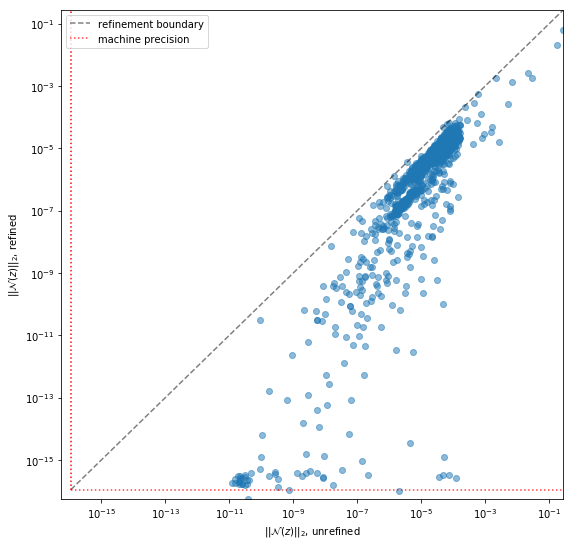

In [58]:

unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

maxval = max(unrefined_Nzs)
#plt.figure(figsize=(12,6))
fig, left = plt.subplots(1,1,figsize=(9,9))
left.set_xscale('log')
left.set_yscale('log')
col = left.scatter(unrefined_Nzs, refined_Nzs, 
                 # c = timeratio, 
                  alpha=.5, 
                 # cmap='magma'
                 )
# cbar = fig.colorbar(col, shrink=.85, 
#                    ticks=[-3, -2, -1 , 0, 1])
# cbar.ax.set_yticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$' , '$10^0$', '$10^1$'])

# cbar.ax.set_ylabel('ref. time / solver time')

left.set_xlabel('$\||\mathcal{N}(z) \||_2$, unrefined')
left.set_ylabel('$\||\mathcal{N}(z) \||_2$, refined')
#plt.title('Suboptimality Comparison')
left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, maxval], 'r:')
left.legend(loc='upper left')
left.set_xlim([EPS/2, maxval])
left.set_ylim([EPS/2, maxval])

plt.savefig('comparison.png')

### Timing analysis 

In [36]:
sol_times = [el['solver_time'] for el in experiment_results]
ref_times = [el['refine_time'] for el in experiment_results]

print('solve time quantiles 10 and 90: ', (np.quantile(sol_times, .1), np.quantile(sol_times, .9)))
print('refine time quantiles 10 and 90: ', (np.quantile(ref_times, .1), np.quantile(ref_times, .9)))

solve time quantiles 10 and 90:  (0.053357410430908206, 8.827041864395147)
refine time quantiles 10 and 90:  (0.10976910591125488, 0.4197042942047119)


In [26]:
# unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
# refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
# timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

# EPS = 1E-16  ##machine precision
# maxval = max(unrefined_Nzs)
# #plt.figure(figsize=(12,6))
# fig, left = plt.subplots(1,1,figsize=(10,8))
# left.set_xscale('log')
# left.set_yscale('log')
# col = left.scatter(unrefined_Nzs, refined_Nzs, 
#                   c = timeratio, 
#                   alpha=.5, 
#                   cmap='magma'
#                  )
# cbar = fig.colorbar(col, shrink=.85)#, 
#                    # ticks=[-3, -2, -1 , 0])
# #cbar.ax.set_yticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$' , '$10^0$'])


# cbar.ax.set_ylabel('log_10 ( ref. time / solver time )')

# left.set_xlabel('unrefined $\||\mathcal{N}(z) \||_2$  ')
# left.set_ylabel('refined $\||\mathcal{N}(z) \||_2$')
# #plt.title('Suboptimality Comparison')
# left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
# plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
# plt.plot([EPS,EPS],[EPS, maxval], 'r:')
# #left.legend(loc='upper left')
# left.set_xlim([EPS, 10.])
# left.set_ylim([EPS, 10.])

# # right.set_xscale('log')
# # right.set_yscale('log')
# # right.scatter( [ el['solver_time']  for el in experiment_results],
# # [el['refine_time'] for el in experiment_results])
# # right.set_xlim([0.001,10])
# # right.set_ylim([0.001,10])
# # right.plot([0.001,10],[0.001,10], 'k--' , alpha= .5,label='refinement boundary')
# # right.set_xlabel('solver time (s)')
# # right.set_ylabel('refinement time (s)')

# plt.savefig('comparison.png')

In [18]:
# plt.figure(figsize=(8,6))
# plt.hist(refined_Nzs / unrefined_Nzs, bins = 50)
# plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')

In [50]:
ref_factor = np.log10(unrefined_Nzs/ refined_Nzs)

print('refinement factor quantiles 10 and 90: ', (np.quantile(ref_factor, .1), np.quantile(ref_factor, .9)))
print('refinement factor mean: ', (np.mean(ref_factor)))




refinement factor quantiles 10 and 90:  (0.40188323296500233, 3.0414989612044407)
refinement factor mean:  1.3666227888026008


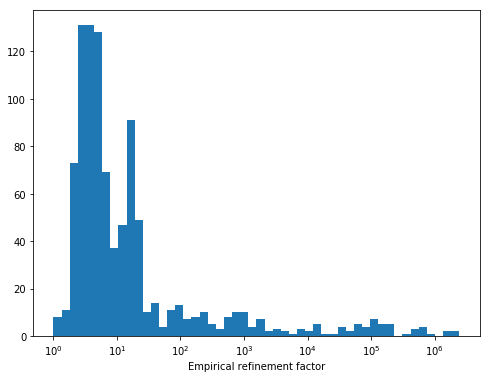

In [47]:
plt.figure(figsize=(8,6))

samples = np.log10(unrefined_Nzs/ refined_Nzs)

samples = samples[samples<6.5]
plt.hist(samples, bins = 50)
#plt.xlim([-5.5, .1])
#plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')
plt.xlabel('Empirical refinement factor')
plt.xticks(range(7), ['$10^{%d}$'%i for i in range(7)])

plt.savefig('improvement.png')

In [20]:
# plt.figure(figsize=(8,6))

# samples = np.log10(refined_Nzs / unrefined_Nzs)

# samples = samples[samples>-5]
# plt.hist(samples, bins = 50)
# plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')

#### Ranges of n and m 

In [33]:
n_s = np.array([el['(m,n)'][1] for el in experiment_results])
m_s = np.array([el['(m,n)'][0] for el in experiment_results])

(array([ 30.,  89., 119., 148., 183., 187., 143.,  69.,  15.,   2.]),
 array([ 271. ,  438.8,  606.6,  774.4,  942.2, 1110. , 1277.8, 1445.6,
        1613.4, 1781.2, 1949. ]),
 <a list of 10 Patch objects>)

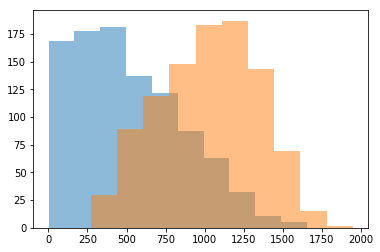

In [34]:
plt.hist(n_s, alpha=.5),
plt.hist(m_s, alpha=.5)

In [35]:
(np.quantile(n_s, .1), np.quantile(n_s, .9)), (np.quantile(m_s, .1), np.quantile(m_s, .9))

((96.4, 1019.0), (581.0, 1423.0))

#### Alternate plot 

/Users/enzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


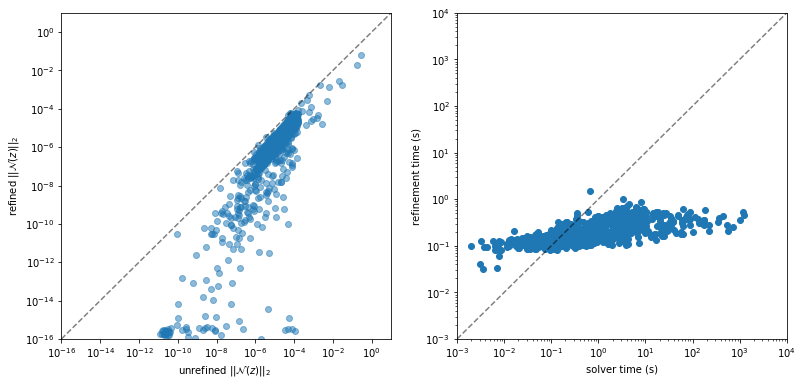

In [25]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#plt.figure(figsize=(12,6))
fig, (left,right) = plt.subplots(1,2,figsize=(13,6))
left.set_xscale('log')
left.set_yscale('log')
col = left.scatter(unrefined_Nzs, refined_Nzs, 
                  #c = timeratio, 
                  alpha=.5, 
                  #cmap='seismic'
                 )
# cbar = plt.colorbar(col, shrink=.85, 
#                     ticks=[-2, -1 , 0])
# cbar.ax.set_yticklabels(['$10^{-2}$', '$10^{-1}$' , '$10^0$'])


# cbar.ax.set_ylabel('ref. time / solver time')

left.set_xlabel('unrefined $\||\mathcal{N}(z) \||_2$  ')
left.set_ylabel('refined $\||\mathcal{N}(z) \||_2$')
#plt.title('Suboptimality Comparison')
left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5)#,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
#left.legend(loc='upper left')
left.set_xlim([EPS, 10.])
left.set_ylim([EPS, 10.])

right.set_xscale('log')
right.set_yscale('log')
right.scatter( [ el['solver_time']  for el in experiment_results],
[el['refine_time'] for el in experiment_results])
right.set_xlim([0.001,10000])
right.set_ylim([0.001,10000])
right.plot([0.001,10000],[0.001,10000], 'k--' , alpha= .5,label='refinement boundary')
right.set_xlabel('solver time (s)')
right.set_ylabel('refinement time (s)')




plt.savefig('comparison_alternate.png')

#### Ranges of refinement and solver times

In [31]:
soltime = [ el['solver_time']  for el in experiment_results]
reftime = [ el['refine_time']  for el in experiment_results]

(np.quantile(soltime, .1), np.quantile(soltime, .9)), (np.quantile(reftime, .1), np.quantile(reftime, .9))

((0.08795013427734374, 12.540558242797857),
 (0.14479057788848876, 0.6941631555557252))

(-4, 2)

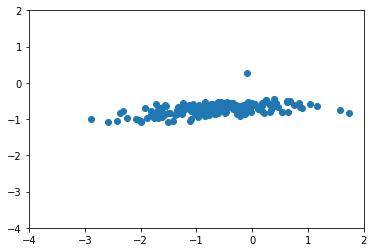

In [16]:
plt.scatter( 
            np.log10([ el['solver_time']  for el in experiment_results]),
np.log10([el['refine_time'] for el in experiment_results]))
plt.xlim([-4,2])
plt.ylim([-4,2])

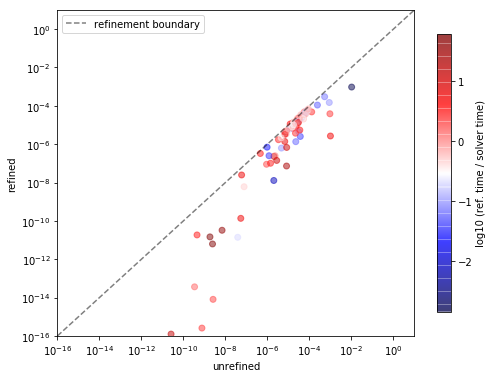

In [6]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])



###100 points, prenumba, eps=1e-6
plt.savefig('comparison.png')

## Interactive plot 

In [61]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show

In [62]:
output_notebook()


Loading BokehJS ...

In [90]:
import pandas as pd
results = pd.DataFrame(data=experiment_results)
results['unrefined_logresnorm'] = np.log10(results['unrefined_resnorm'])
results['refined_logresnorm'] = np.log10(results['refined_resnorm'])

In [91]:
p1 = figure()
p1.scatter(results['unrefined_logresnorm'], results['refined_logresnorm'] )
p1.

#p1.line([EPS, maxval], [EPS, maxval], line_width=2)


show(p1)

In [2]:
greater_than_eps = lambda x: not (1 + x == 1)

def find_eps(prec=1e-30):
    result = 1.
    while greater_than_eps(result):
        result /= 2
    lower = result
    upper = result*2
    while upper-lower>prec:
        mid = (lower + upper)/2
        if greater_than_eps(mid):
            upper = mid
        else:
            lower = mid
    return lower
        
EPS = find_eps()
assert (1 + EPS == 1)
assert not (1 + EPS + 1e-8 == 1)
print('numerical precision of float sum ~', EPS)

print('52 bits mantissa, 2^-53 =', 2**(-53))

numerical precision of float sum ~ 1.1102230246251565e-16
52 bits mantissa, 2^-53 = 1.1102230246251565e-16


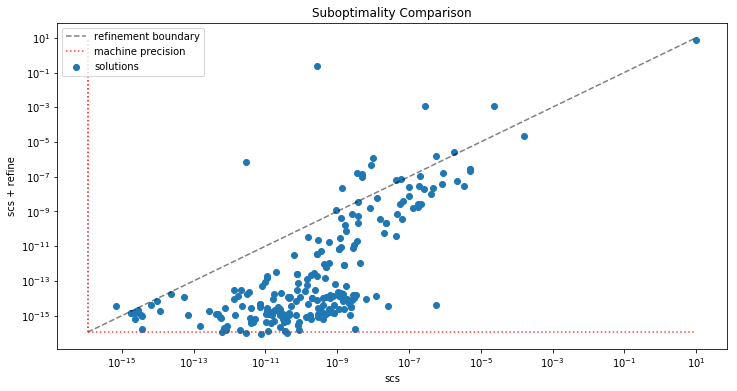

In [86]:
largest = max(max(scs_subopts), max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,largest],[EPS,largest], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,largest],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, largest], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')